# paths etc.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import json
from PIL import Image, ImageDraw, ImageFont
import pickle 



def load_H5_bodypart_new_data(tracking_path,video_type,exclude, tracking_point):

    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
            if not exclude in file:
                back_file = pd.read_hdf(tracking_path + file)     
                
    # drag data out of the df
    scorer = back_file.columns.tolist()[0][0]
    body_part = back_file[scorer][tracking_point]

    parts=[]
    for item in list(back_file[scorer]):
        parts+=[item[0]]
    print(np.unique(parts))

    # clean and interpolate frames with less than 98% confidence
    clean_and_interpolate(body_part,0.98)
    
    return(body_part)

def load_H5_ports_newdata(tracking_path,video_type):

    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
                back_ports_file = pd.read_hdf(tracking_path + file)

    ## same for the ports:
    scorer = back_ports_file.columns.tolist()[0][0]
        
    if video_type == 'back':
        port1 =back_ports_file[scorer]['port2']
        port2 =back_ports_file[scorer]['port1']
        port3 =back_ports_file[scorer]['port6']
        port4 =back_ports_file[scorer]['port3']
        port5 =back_ports_file[scorer]['port7']
    else:
        port1 =back_ports_file[scorer]['Port2']
        port2 =back_ports_file[scorer]['Port1']
        port3 =back_ports_file[scorer]['Port6']
        port4 =back_ports_file[scorer]['Port3']
        port5 =back_ports_file[scorer]['Port7']

    clean_and_interpolate(port1,0.98)
    clean_and_interpolate(port2,0.98)
    clean_and_interpolate(port3,0.98)
    clean_and_interpolate(port4,0.98)
    clean_and_interpolate(port5,0.98)
        
    return(port1,port2,port3,port4,port5)


def sortperm_neurons(bkgd_log_proportions_array,config,neuron_response_df, sequence_ordering=None, th=0.2):
    ## this is number of neurons in total
    N_neurons= bkgd_log_proportions_array.shape[1]
    ## number of sequences from json file 
    n_sequences = config["num_sequence_types"]
    # the 18 neuron params for each neuron from the last iteration
    all_final_globals = neuron_response_df.iloc[-N_neurons:]
    # this cuts it down to just the first 6 params - i think this correspond sto the first param for each seq type? response probABILITY - ie the chance that a neuron spikes in a given latent seq 
    resp_prop = np.exp(all_final_globals.values[:, :n_sequences])#
    # this takes the next 6 params - which i think are the offset values
    offset = all_final_globals.values[-N_neurons:, n_sequences:2*n_sequences]
    ## finds the max response value - ie. which seq it fits to? 
    peak_response = np.amax(resp_prop, axis=1)
    # then threshold the reponse
    has_response = peak_response > np.quantile(peak_response, th)
    # I thin this is the sequence that the neuron has the max response for: ie. we are ordering them by max response 
    preferred_type = np.argmax(resp_prop, axis=1)
    if sequence_ordering is None:
        # order them by max reponse 
        ordered_preferred_type = preferred_type
    else:
        #order them differnetly 
        ordered_preferred_type = np.zeros(N_neurons)#
        # loop through each sequence
        for seq in range(n_sequences):
            # where does  max repsone = user defined seque
            seq_indices = np.where(preferred_type == sequence_ordering[seq])
            # change order to different seq
            ordered_preferred_type[seq_indices] = seq

    # reorder the offset params according to max respsone
    preferred_delay = offset[np.arange(N_neurons), preferred_type]
    Z = np.stack([has_response, ordered_preferred_type+1, preferred_delay], axis=1)
    indexes = np.lexsort((Z[:, 2], Z[:, 1], Z[:, 0]))
    return indexes,ordered_preferred_type

# Function to find corresponding number in another column
def find_corresponding(nums):
    return [df_dict[num] for num in nums]

def split_list(nums):
    sublists = []
    current_sublist = [nums[0]]
    current_element = nums[0]
    for i in range(1,len(nums)):
        if nums[i] == current_element:
            current_sublist.append(nums[i])
        else:
            sublists.append(current_sublist)
            current_sublist = [nums[i]]
            current_element = nums[i]
    sublists.append(current_sublist)
    return sublists

def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def load_H5_bodypart(tracking_path,video_type, tracking_point):

    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
            if 'task' in file:
                back_file = pd.read_hdf(tracking_path + file)     
                
    # drag data out of the df
    scorer = back_file.columns.tolist()[0][0]
    body_part = back_file[scorer][tracking_point]
    
    parts=[]
    for item in list(back_file[scorer]):
        parts+=[item[0]]
    print(np.unique(parts))
    
    # clean and interpolate frames with less than 98% confidence
    clean_and_interpolate(body_part,0.98)
    
    return(body_part)
  
def load_H5_ports(tracking_path,video_type):

    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
            if 'port' in file:
                back_ports_file = pd.read_hdf(tracking_path + file)

    ## same for the ports:
    scorer = back_ports_file.columns.tolist()[0][0]
        
    if video_type == 'back':
        port1 =back_ports_file[scorer]['port2']
        port2 =back_ports_file[scorer]['port1']
        port3 =back_ports_file[scorer]['port6']
        port4 =back_ports_file[scorer]['port3']
        port5 =back_ports_file[scorer]['port7']
    else:
        port1 =back_ports_file[scorer]['Port2']
        port2 =back_ports_file[scorer]['Port1']
        port3 =back_ports_file[scorer]['Port6']
        port4 =back_ports_file[scorer]['Port3']
        port5 =back_ports_file[scorer]['Port7']

    clean_and_interpolate(port1,0.98)
    clean_and_interpolate(port2,0.98)
    clean_and_interpolate(port3,0.98)
    clean_and_interpolate(port4,0.98)
    clean_and_interpolate(port5,0.98)
    
    return(port1,port2,port3,port4,port5)

def list_files(directory, extension):
    return (f for f in os.listdir(directory) if f.endswith('.' + extension))

def clean_and_interpolate(head_centre,threshold):
    bad_confidence_inds = np.where(head_centre.likelihood.values<threshold)[0]
    newx = head_centre.x.values
    newx[bad_confidence_inds] = 0
    newy = head_centre.y.values
    newy[bad_confidence_inds] = 0

    start_value_cleanup(newx)
    interped_x = interp_0_coords(newx)

    start_value_cleanup(newy)
    interped_y = interp_0_coords(newy)
    
    head_centre['interped_x'] = interped_x
    head_centre['interped_y'] = interped_y
    
def start_value_cleanup(coords):
    # This is for when the starting value of the coords == 0; interpolation will not work on these coords until the first 0 
    #is changed. The 0 value is changed to the first non-zero value in the coords lists
    for index, value in enumerate(coords):
        working = 0
        if value > 0:
            start_value = value
            start_index = index
            working = 1
            break
    if working == 1:
        for x in range(start_index):
            coords[x] = start_value
            
def interp_0_coords(coords_list):
    #coords_list is one if the outputs of the get_x_y_data = a list of co-ordinate points
    for index, value in enumerate(coords_list):
        if value == 0:
            if coords_list[index-1] > 0:
                value_before = coords_list[index-1]
                interp_start_index = index-1
                #print('interp_start_index: ', interp_start_index)
                #print('interp_start_value: ', value_before)
                #print('')

        if index < len(coords_list)-1:
            if value ==0:
                if coords_list[index+1] > 0:
                    interp_end_index = index+1
                    value_after = coords_list[index+1]
                    #print('interp_end_index: ', interp_end_index)
                    #print('interp_end_value: ', value_after)
                    #print('')

                    #now code to interpolate over the values
                    try:
                        interp_diff_index = interp_end_index - interp_start_index
                    except UnboundLocalError:
#                         print('the first value in list is 0, use the function start_value_cleanup to fix')
                        break
                    #print('interp_diff_index is:', interp_diff_index)

                    new_values = np.linspace(value_before, value_after, interp_diff_index)
                    #print(new_values)

                    interp_index = interp_start_index+1
                    for x in range(interp_diff_index):
                        #print('interp_index is:', interp_index)
                        #print('new_value should be:', new_values[x])
                        coords_list[interp_index] = new_values[x]
                        interp_index +=1
        if index == len(coords_list)-1:
            if value ==0:
                for x in range(30):
                    coords_list[index-x] = coords_list[index-30]
                    #print('')
#     print('function exiting')
    return(coords_list)

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
    plt.show()
    plt.close()

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

# main

In [16]:
## PATHS
PP_PATH_1 = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\expert\awake\\"
PP_PATH_2 = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\learning\awake\\"
PP_PATH_3 = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\prioritisation_data\awake\\"

'seq006_1_8','seq006_1_9','seq006_1_10','ap5R_1_2','ap5R_1_3','seq006_1_1','seq006_1_3','seq006_1_4','seq006_1_5','seq006_1_6','seq007_1_1','seq007_1_2','seq006_1_11',

list_ = ['ap5R_1_1','seq007_1_3']




ap5R_1_1
ap5R_1_1_run_1102025_1103


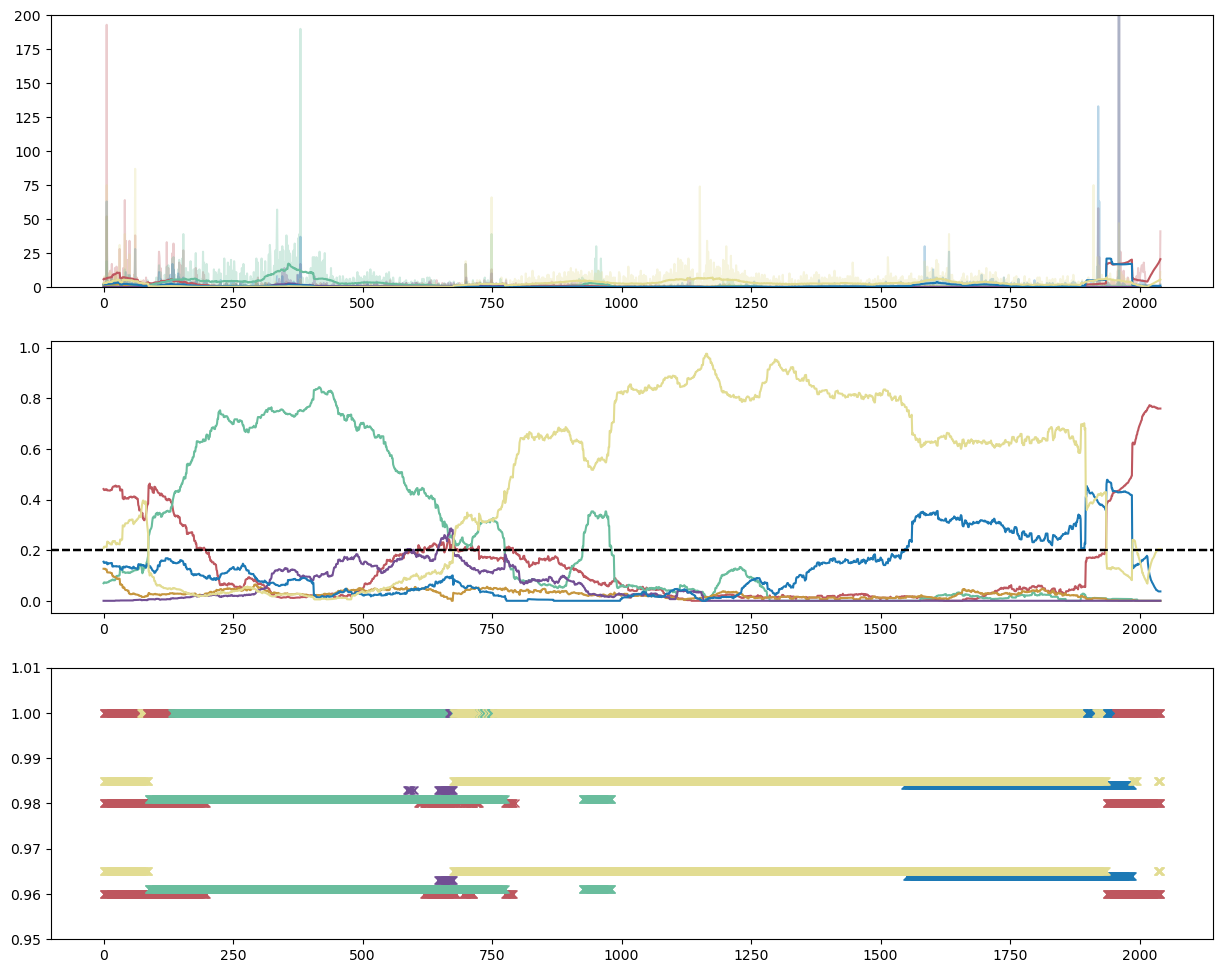

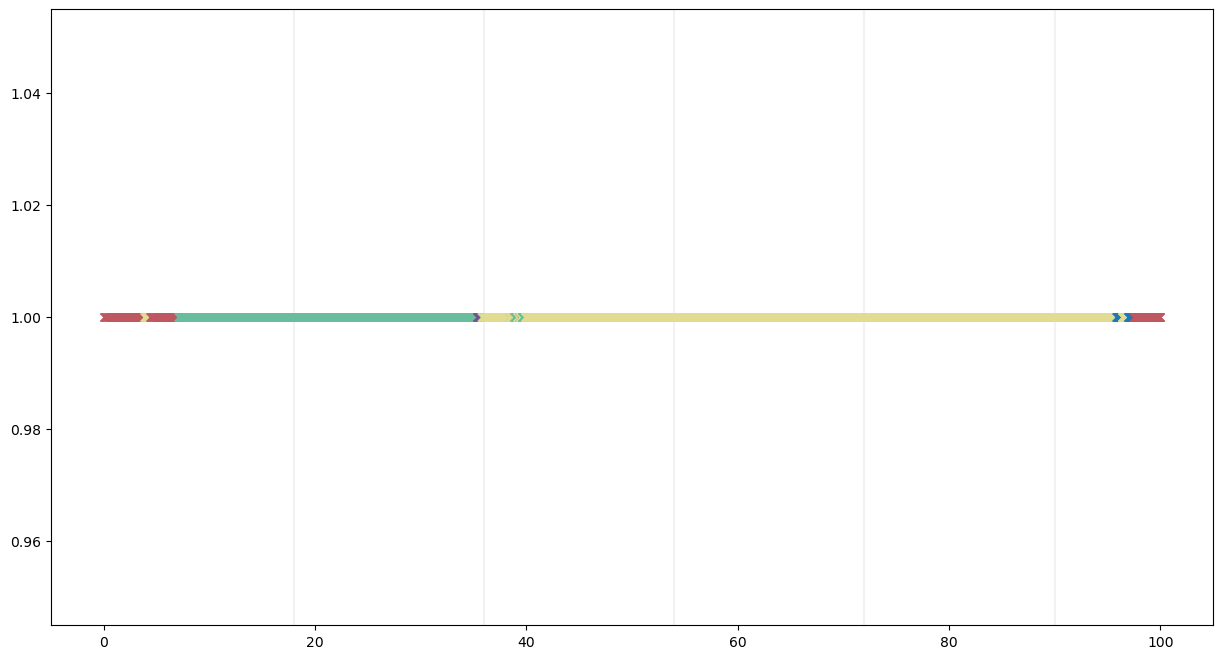

done
seq007_1_3
seq007_1_3_run_1503025_1531


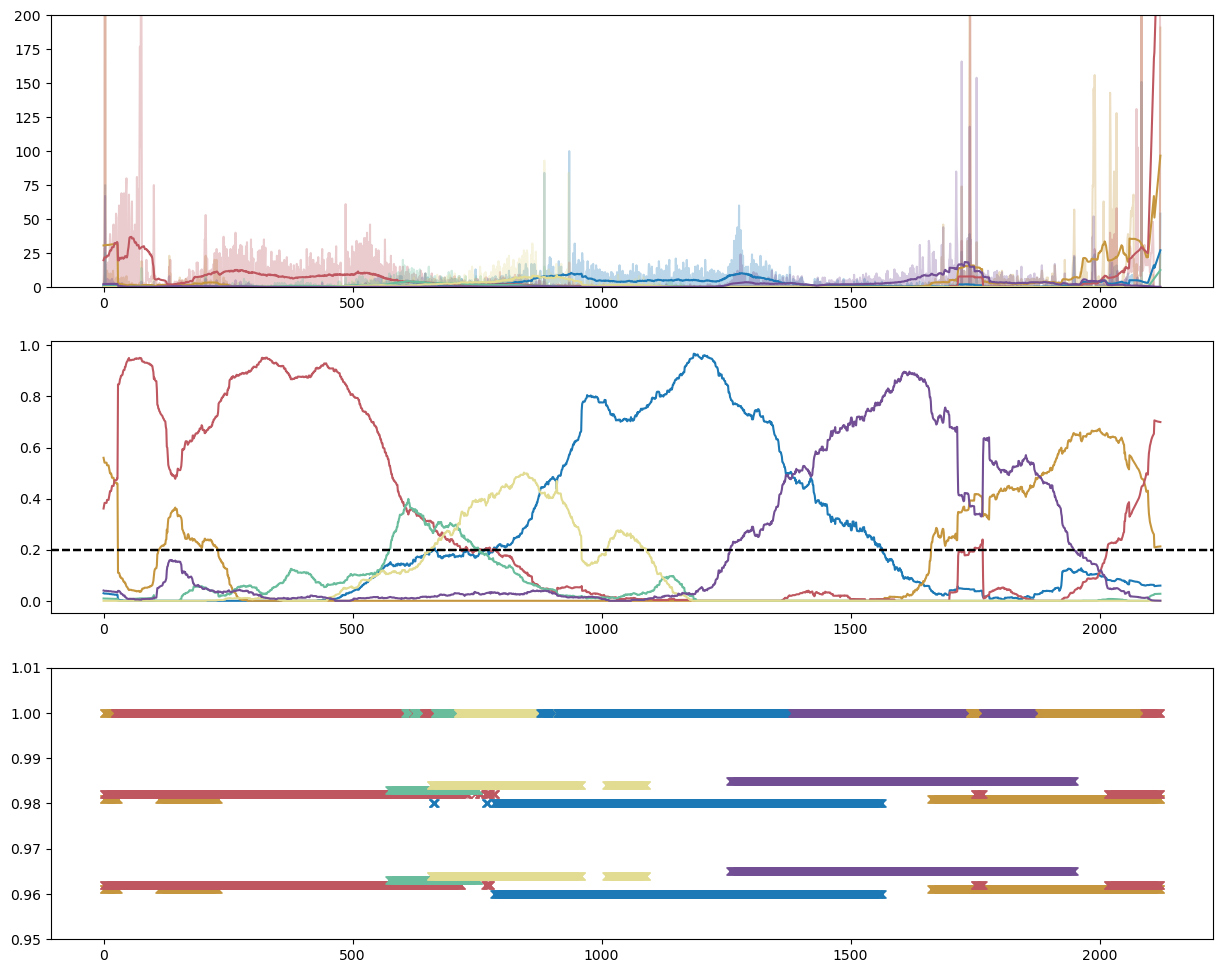

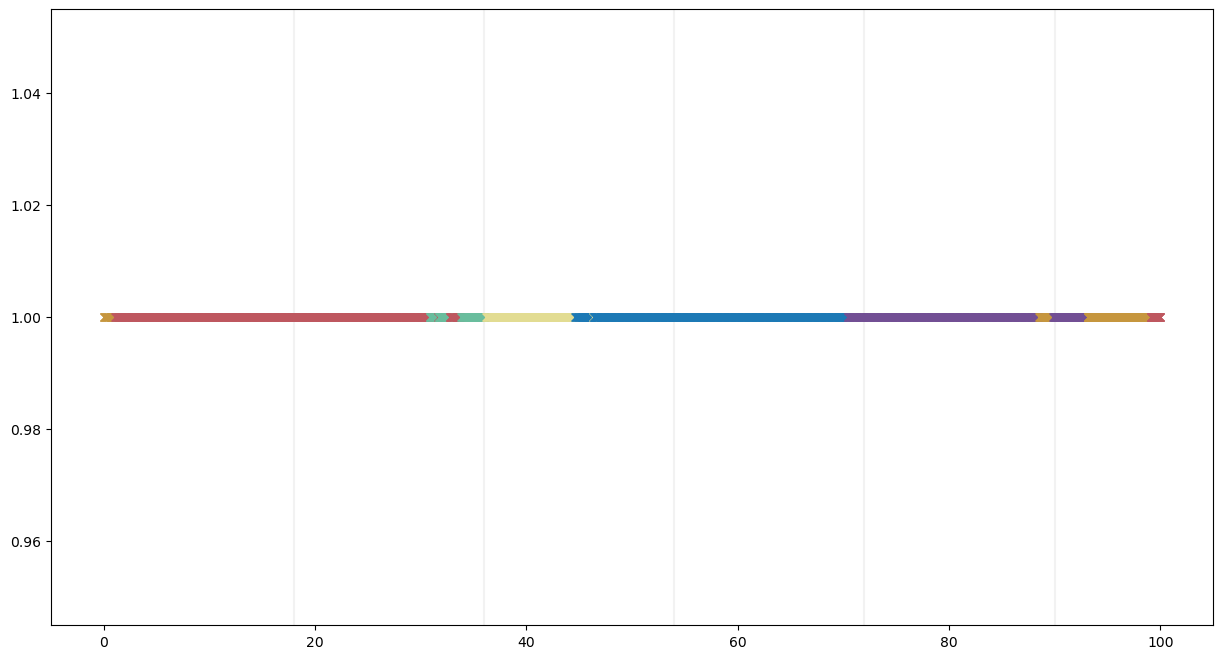

done


In [17]:
for mouse_session_recording in list_:
    
    #### LOAD THE DATA AND PATHS

    print(mouse_session_recording)

    file = None
    PP_PATH = None
    
    for file_ in os.listdir(PP_PATH_1):
        if mouse_session_recording in file_:
            file = file_
            PP_PATH = PP_PATH_1
    if file == None:
        for file_ in os.listdir(PP_PATH_2):
            if mouse_session_recording in file_:
                file = file_
                PP_PATH = PP_PATH_2
    if file == None:
        for file_ in os.listdir(PP_PATH_3):
            if mouse_session_recording in file_:
                file = file_
                PP_PATH = PP_PATH_3
    print(file)

    save_path = PP_PATH + file + r'\\analysis_output\reordered_recolored\fixed_standard_space\\'

    # load colors
    with open(os.path.join(os.path.join(PP_PATH,file) + r"\analysis_output\reordered_recolored\colors"), "rb") as input_file:
        colors = pickle.load(input_file)

    # load binned sequence occurrence data
    a = pd.read_csv(PP_PATH + file + r"\analysis_output\reordered_recolored\binned_seq_occurance_df.csv")
    # extract the counts
    counts = []
    for header in list(a):
        if 'counts' in header:
            counts += [a[header].values]


    nrow = 3 
    ncol = 1
    fig, axs = plt.subplots(nrow, ncol,figsize=(15, 12))
    from itertools import groupby

    for ind, ax in enumerate(fig.axes):

        # for item in av_curve_closestport_indicies[0]:
        #     ax.axvline(item,color = 'grey', alpha = 0.1)

        if ind == 0: # subplot 1
            ax.plot(counts[0],color = colors[1],alpha = 0.3)
            ax.plot(counts[1],color = colors[2],alpha = 0.3)
            ax.plot(counts[2],color = colors[3],alpha = 0.3)
            ax.plot(counts[3],color = colors[4],alpha = 0.3)
            ax.plot(counts[4],color = colors[5],alpha = 0.3)
            ax.plot(counts[5],color = colors[6],alpha = 0.3)

            smoothed_counts = []
            conv_window = 50
            for i,count in enumerate(counts):
                ax.plot(convolve_movmean(count, conv_window), color = colors[i+1] )
                smoothed_counts += [convolve_movmean(count, conv_window)]
            ax.set_ylim(0,200)
            total_smoothed_counts = np.array(smoothed_counts).sum(axis=0)

        elif ind==1:
            for i in range(6):
                ax.plot(smoothed_counts[i]/total_smoothed_counts, color = colors[i+1])   
                ax.axhline(0.2, color='k', linestyle='--')
        else: # subplot 3
            dominant = []
            for item in conactinate_nth_items(smoothed_counts[:]):
                dominant += [np.argmax(item)+1]

            # absolute dominant (no_overlap)
            for i in range(len(dominant)):
                ax.plot(np.linspace(0,len(dominant)-1,len(dominant))[i],1,'x', color = (np.array(colors)[dominant])[i])

            # overlaps with short bouts   
            overlap_color = []
            threshold = 0.2
            for seq in range(6):
                over_thr_mask = (np.array(smoothed_counts[seq])/total_smoothed_counts) > threshold # 20% of the activity is explained by this motif
                ax.plot(np.linspace(0,len(dominant)-1,len(dominant)), (0.98+0.001*(seq%6))*over_thr_mask,'x', color = np.array(colors)[seq+1], alpha=1)

                # get rid of short isolated motifs
                c = 0
                split_motifs = groupby(over_thr_mask)
                start_over_thr = False
                for over_thr, points in split_motifs:
                    if c==0 and over_thr==True: # keep in mind if a fragment of the motif starts from the beginning of the trial 
                        start_over_thr = True 
                    points = list(points)
                    if over_thr==True: # fragment of motif over threshold (over the threshold)
                        if len(points) < 10 and c+len(points)<len(over_thr_mask): # too short and not at the extremity
                            over_thr_mask[c:c+len(points)] = False # do not count them as a relevant motif
                            change_made = True
                        elif len(points) < 10 and not(start_over_thr): # too short at the right extremity but not at the left extremity
                            over_thr_mask[c:c+len(points)] = False # do not count them as a relevant motif 
                            change_made = True
                    c += len(points)
                overlap_color.append(over_thr_mask)

                # overlaps without short bouts 
                ax.plot(np.linspace(0,len(dominant)-1,len(dominant)), (0.96+0.001*(seq%6))*over_thr_mask,'x', color = np.array(colors)[seq+1])

            ax.set_ylim([0.95,1.01])
            

    SaveFig('standard_space_dominant_thrsholded_smallremoved.png',save_path)


    overlap_positions_standard_space = []
    overlap_positions = []

    # overlaps with short bouts   
    overlap_color = []
    threshold = 0.2
    for seq in range(6):
        over_thr_mask = (np.array(smoothed_counts[seq])/total_smoothed_counts) > threshold # 20% of the activity is explained by this motif
        ax.plot(np.linspace(0,len(dominant)-1,len(dominant)), (0.98+0.001*(seq%6))*over_thr_mask,'x', color = np.array(colors)[seq+1], alpha=1)

        # get rid of short isolated motifs
        c = 0
        split_motifs = groupby(over_thr_mask)
        start_over_thr = False
        for over_thr, points in split_motifs:
            if c==0 and over_thr==True: # keep in mind if a fragment of the motif starts from the beginning of the trial 
                start_over_thr = True 
            points = list(points)
            if over_thr==True: # fragment of motif over threshold (over the threshold)
                if len(points) < 10 and c+len(points)<len(over_thr_mask): # too short and not at the extremity
                    over_thr_mask[c:c+len(points)] = False # do not count them as a relevant motif
                    change_made = True
                elif len(points) < 10 and not(start_over_thr): # too short at the right extremity but not at the left extremity
                    over_thr_mask[c:c+len(points)] = False # do not count them as a relevant motif 
                    change_made = True
            c += len(points)
        overlap_color.append(over_thr_mask)

        overlap_positions += [list(np.linspace(0,len(smoothed_counts[0])-1,len(smoothed_counts[0]))[overlap_color[seq]].astype(int))]

        ###  convert to standard space:
        overlap_positions_standard_space += [list(np.linspace(0,len(smoothed_counts[0])-1,len(smoothed_counts[0]))[overlap_color[seq]] / len(overlap_color[seq]) * 100)]

    # warp this to standard space:


    dominant = []
    for bin_ in conactinate_nth_items(smoothed_counts):
        dominant += [np.argmax(bin_)+1]

    def map_y_to_x(y, indices, x_positions):
        x = np.zeros_like(y)
        for i, idx in enumerate(indices):
            x[idx] = x_positions[i]
        x = np.interp(np.arange(len(y)), indices, x_positions)
        x = np.interp(x, (x.min(), x.max()), (0, 100))
        return x

    # Example y data and indices to map to x positions
    # warp_points = [0] + av_curve_closestport_indicies[0] + [len(dominant)-1]
    warp_points = list(np.linspace(0,len(dominant)-1,7).astype(int))
    x_positions = [0,18, 36, 54, 72, 90,100]
    x_values = np.linspace(0, len(dominant)-1, len(dominant))
    warped_x = map_y_to_x(x_values, warp_points, x_positions)

    nrow = 1
    ncol = 1
    fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

    for ind, ax in enumerate(fig.axes):

        for item in x_positions[1:-1]:
            ax.axvline(item,color = 'grey', alpha = 0.1)

        for i in range(len(dominant)):
            plt.plot(warped_x[i], 1,'x', color = (np.array(colors)[dominant])[i])


    SaveFig('standard_space_warped.png',save_path)

    #### save it out 

    count_df = pd.DataFrame({})
    for i in range(len(counts)):
        count_df['seq_' + str(i) + '_counts'] = counts[i]

    count_df.to_csv(save_path + '/binned_seq_occurance_df.csv')    

    obj = np.array(overlap_positions, dtype=object)
    np.save(save_path + '/overlap_positions.npy', obj, allow_pickle=True)
    
    obj = np.array(overlap_positions_standard_space, dtype=object)
    np.save(save_path + '/overlap_positions_standard_space.npy', obj, allow_pickle=True)

    np.save(save_path+ '/smoothed_counts.npy', smoothed_counts)

    np.save(save_path+ '/warped_x.npy', warped_x)

    print('done')




# old unecessisary 

seq006_1_8
seq006_1_8_run_1102025_0102


LOADING processed_spike_data


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_45968\3811700684.py:52: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  spikes_seq_type_adjusted = pickle.load(input_file)
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_45968\3811700684.py:56: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, mos

ABOVE_CAM_seq006_25-11-2024DLC_resnet50_ABOVE_generalDec4shuffle1_650000.h5
BACK_CAM_seq006_25-11-2024DLC_resnet50_BACK_hippocampusDec10shuffle1_800000.h5
BACK_CAM_seq006_25-11-2024DLC_resnet50_BACK_PORTS_hpc_rigDec4shuffle1_640000.h5
['head_centre']
ABOVE_CAM_seq006_25-11-2024DLC_resnet50_ABOVE_generalDec4shuffle1_650000.h5
BACK_CAM_seq006_25-11-2024DLC_resnet50_BACK_hippocampusDec10shuffle1_800000.h5
BACK_CAM_seq006_25-11-2024DLC_resnet50_BACK_PORTS_hpc_rigDec4shuffle1_640000.h5
      A corresponding time span has been found. Time span set to [6900, 8000]


LOADING BEHAV DATA
done


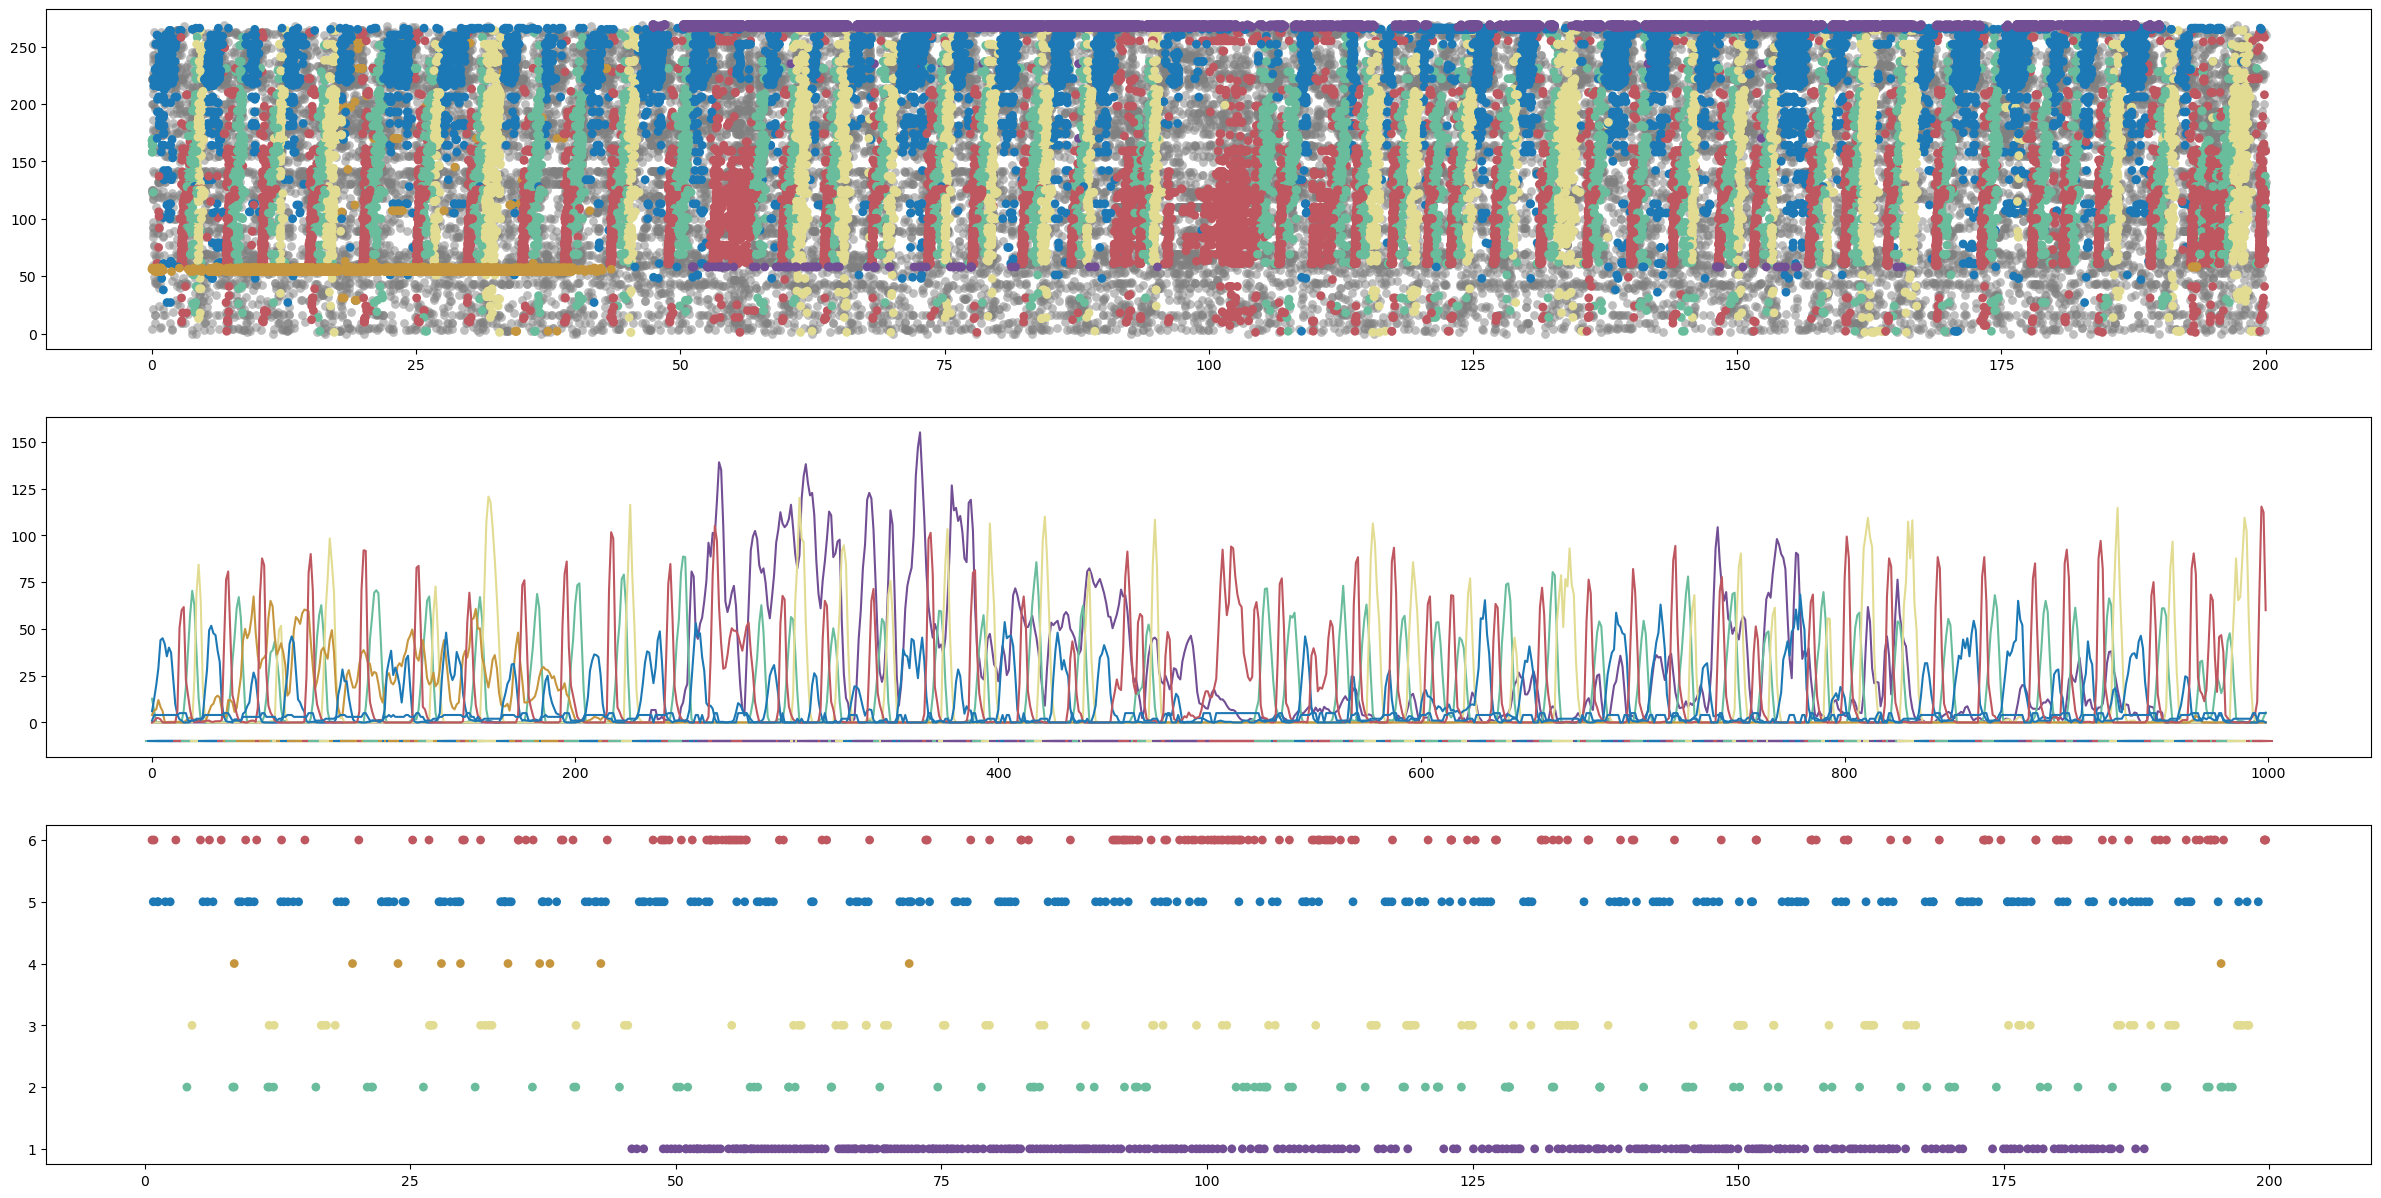

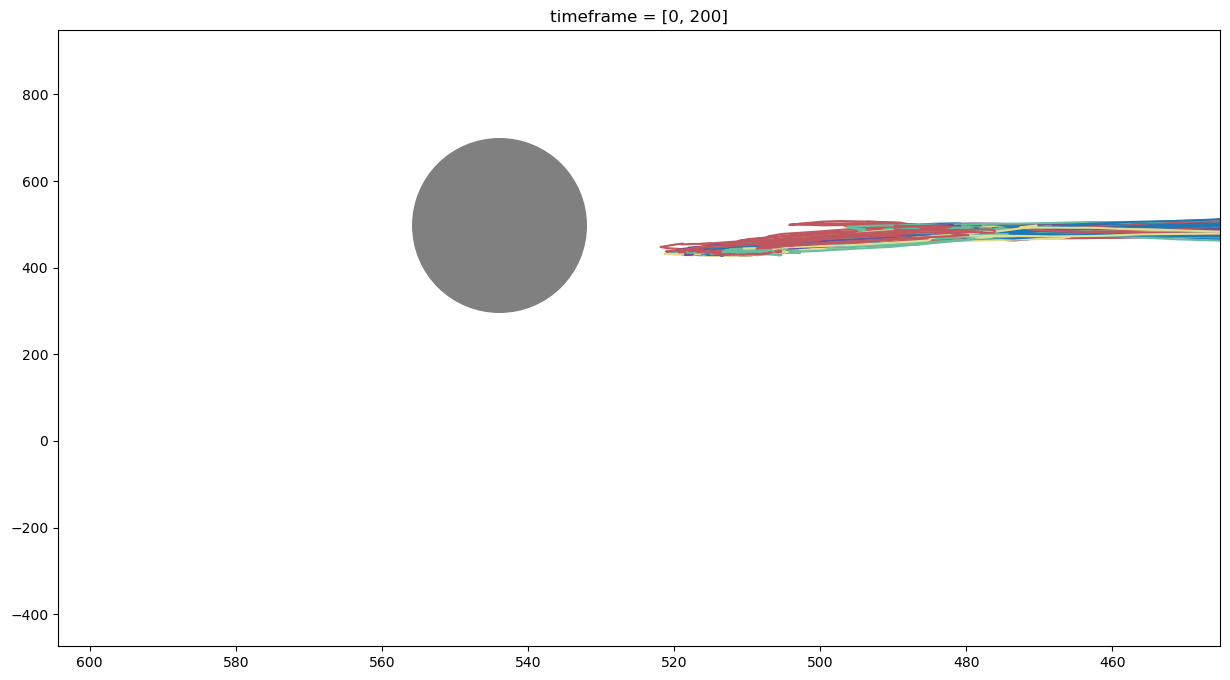

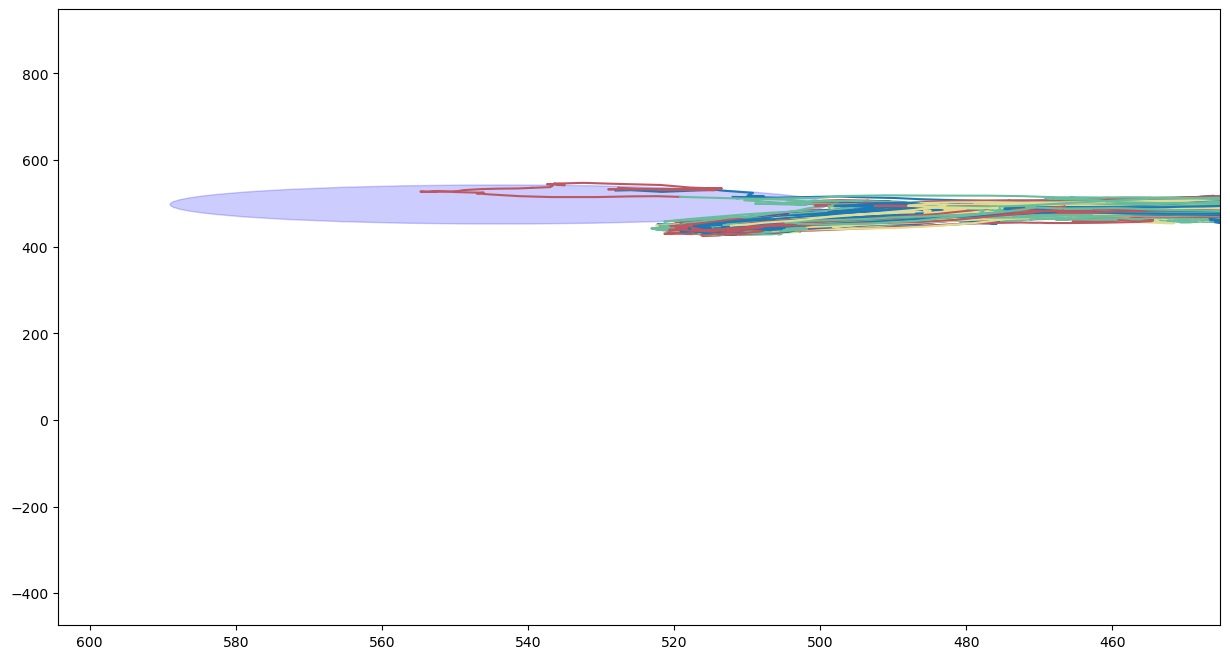

NameError: name 'standard' is not defined

In [53]:

for mouse_session_recording in list_:
    

    #### LOAD THE DATA AND PATHS

    print(mouse_session_recording)

    file = None
    PP_PATH = None
    
    for file_ in os.listdir(PP_PATH_1):
        if mouse_session_recording in file_:
            file = file_
            PP_PATH = PP_PATH_1
    if file == None:
        for file_ in os.listdir(PP_PATH_2):
            if mouse_session_recording in file_:
                file = file_
                PP_PATH = PP_PATH_2
    if file == None:
        for file_ in os.listdir(PP_PATH_3):
            if mouse_session_recording in file_:
                file = file_
                PP_PATH = PP_PATH_3
    print(file)

    save_path = PP_PATH + file + r'\\analysis_output\reordered_recolored\fixed_standard_space\\'

    ## set dat_path:
    for file_ in os.listdir(DAT_PATH):
        if mouse_session_recording.split('_')[0] in file_:
            if mouse_session_recording.split('_')[1] == file_[-1]:
                dat_path = os.path.join(DAT_PATH,file_)
    for recording in os.listdir(os.path.join(DAT_PATH,dat_path)):
        if recording.split('_')[0][9::] == mouse_session_recording.split('_')[-1]:
            dat_path = os.path.join(dat_path,recording)

    # set tracking path
    if not 'seq' or 'ap5' in mouse_session_recording: 
        for file_ in os.listdir(dat_path + r"\video\tracking\\"):
            if 'task' in file_:
                if not 'clock' in file_:
                    tracking_path = os.path.join(dat_path + "\video\tracking\\",file_) + '\\'
    else:
        tracking_path = dat_path+r"\video\tracking\\"

    print('\n')
    print("LOADING processed_spike_data")
    ### load in releavent things:

    with open(PP_PATH + file + "\\analysis_output\\" + "spikes_seq_type_adjusted.pickle", "rb") as input_file:
        spikes_seq_type_adjusted = pickle.load(input_file)

    import pickle
    with open(PP_PATH + file + "\\analysis_output\\" + "spikes_seq_type_adjusted.pickle", "rb") as input_file:
        unmasked_spikes_df = pickle.load(input_file)

    with open(os.path.join(os.path.join(PP_PATH,file) + r"\analysis_output\reordered_recolored\neuron_order"), "rb") as input_file:
        neuron_order = pickle.load(input_file)

    with open(os.path.join(os.path.join(PP_PATH,file) + r"\analysis_output\reordered_recolored\colors"), "rb") as input_file:
        colors = pickle.load(input_file)

    with open(os.path.join(os.path.join(PP_PATH,file) + r"\analysis_output\reordered_recolored\neuron_index"), "rb") as input_file:
        neuron_index = pickle.load(input_file)

    with open(PP_PATH + file + "\\analysis_output\\" + "latent_event_history_df_split.pickle", "rb") as input_file:
        latent_event_history_df_split = pickle.load(input_file)

    ordered_preferred_type = np.load(PP_PATH + file + "\\analysis_output\\" + 'ordered_preferred_type.npy')

    bkgd_log_proportions_array = pd.read_csv(PP_PATH + file + r"\bkgd_log_proportions_array.csv")

    ##### load deeplabcut tracking data
    if 'seq' or 'ap5' in mouse_session_recording:
        back_head_centre = load_H5_bodypart_new_data(tracking_path,'BACK','PORTS','head_centre')
        back_p1,back_p2,back_p3,back_p4,back_p5 = load_H5_ports_newdata(tracking_path,'PORTS')
    else:
        back_head_centre = load_H5_bodypart(tracking_path,'back','head_centre')
        back_p1,back_p2,back_p3,back_p4,back_p5 = load_H5_ports(tracking_path,'back')

    ## load in the timespan used for pppseq:
    input_params_path = os.path.join(PP_PATH + file,'trainingData\\') + ('params_' + mouse_session_recording +'.json')
    # Opening JSON file
    f = open(input_params_path)
    # returns JSON object as  a dictionary
    input_config = json.load(f)
    behav_time_interval_start = input_config['time_span'][0]
    print(f"      A corresponding time span has been found. Time span set to {behav_time_interval_start}")


    ## LOAD behaviour data
    print('\n')
    print("LOADING BEHAV DATA")
    try:
        behav_sync = pd.read_csv(dat_path + r'\behav_sync\2_task\Behav_Ephys_Camera_Sync.csv')
        transitions = pd.read_csv(dat_path + r'\behav_sync\2_task\Transition_data_sync.csv')
    except:
        behav_sync = pd.read_csv(dat_path + r'\behav_sync\1_task\Behav_Ephys_Camera_Sync.csv')
        transitions = pd.read_csv(dat_path + r'\behav_sync\1_task\Transition_data_sync.csv')

    behav_mask = (behav_sync.PokeIN_EphysTime>behav_time_interval_start[0])*(behav_sync.PokeIN_EphysTime<behav_time_interval_start[1])
    poke_in_times = (behav_sync[behav_mask].PokeIN_EphysTime) - behav_time_interval_start[0]
    ports = behav_sync[behav_mask].Port
    print('done')



    timeframe = [0,200]

    #mask
    # spikemask
    mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])

    fig, [ax1,ax2,ax3] = plt.subplots(3, 1,figsize=(30, 15))

    1 ### plot ordered ppseq spikes as above:

    # plot background in grey 
    background_keep_mask = unmasked_spikes_df[mask].sequence_type_adjusted <= 0
    ax1.scatter(unmasked_spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=40, linewidth=0,color = 'grey' ,alpha=0.5)
    # mask to remove background neurons from the color plot
    background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
    c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
    ax1.scatter(unmasked_spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)


    ### bin the spiking and plot number of spikes for each seq type
    seqs = np.unique(unmasked_spikes_df.sequence_type_adjusted)
    seq_spikes = []
    for seq_type_ in seqs:  
        seq_spikes += [unmasked_spikes_df.timestamp[np.where(unmasked_spikes_df.sequence_type_adjusted ==seq_type_)[0]].values]

    # Define the bin size (in this case, 0.2s)
    bin_size = 0.2

    seq_spike_occurance = []
    for spikes_ in seq_spikes:
        # Use the numpy.histogram function to bin the data
        hist, bins = np.histogram(spikes_, bins=np.arange(0, np.diff(behav_time_interval_start)[0], bin_size))
        seq_spike_occurance += [list(hist)]

    strt_ = int(timeframe[0]/bin_size)
    end_ = int(timeframe[1]/bin_size)

    for i in range (1,len(seq_spike_occurance)):
    #     ax2.plot(seq_spike_occurance[i][strt_:end_], c = colors[i])
        ax2.plot(convolve_movmean(seq_spike_occurance[i][strt_:end_],3), c = colors[i])


    ## plot the current seq type (based on binned spiking):
    nth_vectors = conactinate_nth_items(seq_spike_occurance[1::])
    max_index= []
    max_index += [np.argmax(sublist) for sublist in nth_vectors] 

    ax2.plot(max_index[strt_:end_])

    ax2.scatter(np.linspace(0,end_ - strt_-1,end_ - strt_),np.ones(end_ - strt_)*-10, marker = '_',color = np.array(colors)[np.array(max_index)+1][strt_:end_], s = 100)

    ### plot the ppseq latent:

    # mask for the timespan
    latent_timespan_mask = (latent_event_history_df_split.timestamp>timeframe[0])*(latent_event_history_df_split.timestamp<timeframe[-1])

    # ignore anything that is below threshold * max amplitude
    thr_ = 0
    thresh_value = max(latent_event_history_df_split.amplitude) * thr_


    amplitude_mask = latent_event_history_df_split[latent_timespan_mask].amplitude > thresh_value

    c_l = np.array(colors)[latent_event_history_df_split[latent_timespan_mask][amplitude_mask].seq_type.values.astype(int)]
    ax3.scatter(latent_event_history_df_split[latent_timespan_mask][amplitude_mask].timestamp,latent_event_history_df_split[latent_timespan_mask][amplitude_mask].seq_type ,marker = 'o', s=40, linewidth=0,color = c_l ,alpha=1)


    # SaveFig('seq_identities.png',save_path)

    fps = 60
    if mouse_session_recording == '148_2_2':
        fps = 40

    # behav_mask
    mask_ = (poke_in_times > timeframe[0]) * (poke_in_times < timeframe[1])

    # tracking and ehys times are synced to poke in times so tracking position has to be aligned to first poke in time in this timeframe. 

    # Find the difference between PokeIN_EphysTime and the start of the behavior interval
    interval_pokeIn_spike_times = behav_sync.PokeIN_EphysTime[behav_mask][mask_].values - behav_time_interval_start[0]
    # Find the offset between the first poke in time and the start of the timeframe
    tracking_offset = interval_pokeIn_spike_times[0] - timeframe[0]

    # Get the first synced time for the camera in the interval 
    interval_cam_times =  behav_sync.backcam_aligned_pokein_times[behav_mask][mask_].values[0]
    # Align the tracking start with the ephys by subtracting the offset
    cam_start_time = interval_cam_times - tracking_offset

    # Calculate the number of events based on the timeframe size and bin size
    events = np.diff(timeframe)[0] /bin_size 
    # Create a list for start times, with the first start time being the camera start time converted to timestamps - 60fps
    start_ts = [cam_start_time * fps ]
    # Convert the bin size to timestamps - 60fps
    bin_ts = bin_size * fps

    # Create an empty list for end times
    end_ts = []
    # Loop through the number of events
    for i in range(int(events)):
        # If it is not the first event, set the start time as the end time of the previous event
        if i > 0:
            start_ts += [end_ts[i-1]]
        # Add the current start time plus the bin size to the list of end times
        end_ts += [start_ts[i] + bin_ts] 



    nrow = 1 
    ncol = 1
    fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

    for ind, ax in enumerate(fig.axes):
        for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
            ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125)
        for i in range(int(events)):
            ax.plot(back_head_centre['interped_x'].values[int(start_ts[i])-1:int(end_ts[i])+1],back_head_centre['interped_y'].values[int(start_ts[i])-1:int(end_ts[i])+1],'-',color = np.array(colors)[np.array(max_index)+1][strt_:end_][i], alpha = 1)


        min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        ax.set_xlim(min_x,max_x)
        ax.set_ylim(min_y,max_y)

        ax.invert_yaxis()

    ax.set_title('timeframe = ' + str(timeframe))



    # behav_mask for the whole analysed time:
    mask_ = (poke_in_times > 0) * (poke_in_times < np.diff(behav_time_interval_start)[0])
    # tracking and ehys times are synced to poke in times so tracking position has to be aligned to first poke in time in this timeframe. 

    # Find the difference between PokeIN_EphysTime and the start of the behavior interval
    interval_pokeIn_spike_times = behav_sync.PokeIN_EphysTime[behav_mask][mask_].values - behav_time_interval_start[0]
    # Find the offset between the first poke in time and the start of the timeframe
    tracking_offset = interval_pokeIn_spike_times[0]

    # Get the first synced time for the camera in the interval 
    interval_cam_times =  behav_sync.backcam_aligned_pokein_times[behav_mask][mask_].values
    # Align the tracking start with the ephys by subtracting the offset
    cam_start_time = interval_cam_times[0] - tracking_offset
    cam_end_time = cam_start_time + np.diff(behav_time_interval_start)[0]

    cam_start_ts = cam_start_time * fps
    cam_end_ts = cam_end_time * fps

    ## work out colors:

    full_timeframe = [0,np.diff(behav_time_interval_start)[0]]
    # Calculate the number of events based on the timeframe size and bin size
    events = np.diff(full_timeframe)[0] /bin_size 
    # Convert the bin size to timestamps - 60fps
    bin_ts = bin_size * fps


    ### bin the spiking and plot number of spikes for each seq type
    seqs = np.unique(spikes_seq_type_adjusted.sequence_type_adjusted)
    seq_spikes = []
    for seq_type_ in seqs:  
        seq_spikes += [spikes_seq_type_adjusted.timestamp[np.where(spikes_seq_type_adjusted.sequence_type_adjusted ==seq_type_)[0]].values]

    seq_spike_occurance = []
    for spikes_ in seq_spikes:
        # Use the numpy.histogram function to bin the data
        hist, bins = np.histogram(spikes_, bins=np.arange(0, np.diff(behav_time_interval_start)[0], bin_size))
        seq_spike_occurance += [list(hist)]



    ## plot the current seq type (based on binned spiking):
    nth_vectors = conactinate_nth_items(seq_spike_occurance[1::])
    max_index= []
    max_index += [np.argmax(sublist) for sublist in nth_vectors] 

    frame_colors= []
    bin_colors = np.array(colors)[np.array(max_index)+1]
    for bin_color in bin_colors:
        frame_colors += [bin_color] * int(bin_ts)


    # Loop through the number of events to split this up for plotting:
    seg_start_ts = [cam_start_ts] 
    seg_end_ts= []
    for i in range(len(bin_colors)):
        # If it is not the first event, set the start time as the end time of the previous event
        if i > 0:
            seg_start_ts += [seg_end_ts[i-1]]
        # Add the current start time plus the bin size to the list of end times
        if i == len(bin_colors)-1:
            seg_end_ts += [cam_end_ts] 
        else:
            seg_end_ts += [seg_start_ts[i] + bin_ts] 


    nrow = 1 
    ncol = 1
    fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

    for ind, ax in enumerate(fig.axes):
        port_centroids = []
        for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
            ## define rings around important ports: port 5, port2, port 3, port4
            port_centroid = np.median(item['interped_x'].values),np.median(item['interped_y'].values)
            radius = 45
            circle1 = plt.Circle(port_centroid, radius, color='blue', alpha = 0.2)
            ax.add_patch(circle1)
            port_centroids += [port_centroid]
    #         ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125)


        ## plot binned segments individually
        for i in range(len(bin_colors)):
            x = back_head_centre['interped_x'].values[int(seg_start_ts[i])-1:int(seg_end_ts[i])]
            y = back_head_centre['interped_y'].values[int(seg_start_ts[i])-1:int(seg_end_ts[i])]
            ax.plot(x,y,'-',color = bin_colors[i], alpha = 1)



        min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        ax.set_xlim(min_x,max_x)
        ax.set_ylim(min_y,max_y)

        ax.invert_yaxis()

        #save out this data for later plotting and alanylis 
        # trim it down - it doesnt match because we add extra an extra time bin onto the end so that we know what the final left over frames should be coloree
        total_frames = len(back_head_centre['interped_x'].values[int(cam_start_ts)-1:int(cam_end_ts)])

        all_frame_colors = frame_colors[0:total_frames]
        all_x_position = back_head_centre['interped_x'].values[int(cam_start_ts)-1:int(cam_end_ts)]
        all_y_position = back_head_centre['interped_y'].values[int(cam_start_ts)-1:int(cam_end_ts)]


    SaveFig('tracking_port_radius.png',save_path)


    ## find times it comes within ble circles (distance is less than radius)
    ## find times it does so in the order 5,2,3,4,5 with less than 2s between 

    def closest_points(target, points, threshold):
        import math
        closest = []
        indicies = []
        for index,point in enumerate(points):
            distance = math.dist(target,point)
            if distance <= threshold:
                closest.append(point)
                indicies.append(index)
        return closest,indicies

    def find_next_val(index,threshold_breaks,frame_filter,port_type):
        p2_indicies = np.where(threshold_breaks == port_type)[0]
        try:
            p2_min_val = min(i for i in p2_indicies if i > index)
            distance = p2_min_val - index
        except:
            distance = 9999999
        if distance<frame_filter:
            return p2_min_val
        else:
            return -1


    coords = []
    for ind_,item in enumerate(all_x_position):
        coords += [[item,all_y_position[ind_]]]

    threshold_breaks = np.zeros(len(coords))
    # for each port we care about find where the mouse breaks the distcance threshold
    for ind_ in range(1,len(port_centroids)):
        threshold = radius
        target = port_centroids[ind_]
        closest,indicies = closest_points(target, coords, threshold)
        threshold_breaks[indicies] = ind_ + 1

    ## each of these is a frame so we know the timing between them. ie. one frame is 1/60s 
    time_filter = 3 #in s
    frame_filter = int(time_filter / (1/fps))


    # #find times when the mouse does the sequence:


    if standard:

        start_ind = []
        end_ind = []
        P5_in_ind = []
        index = 0
        while index < len(threshold_breaks[:-1]):
        # for index,break_ in enumerate(threshold_breaks[:-1]):
            break_ = threshold_breaks[index]
            if break_ == 5 and not threshold_breaks[index+1] ==5:
                # find min valin this that is larger than current - ie. next index
                p2_ind = find_next_val(index,threshold_breaks,frame_filter,2)
                if p2_ind != -1:
                    # find min valin this that is larger than current - ie. next index
                    p3_ind = find_next_val(p2_ind,threshold_breaks,frame_filter,3)
                    if p3_ind != -1:
                        # find min valin this that is larger than current - ie. next index
                        p4_ind = find_next_val(p3_ind,threshold_breaks,frame_filter,4)
                        if p4_ind != -1:
                            # find min valin this that is larger than current - ie. next index
                            p5_ind = find_next_val(p4_ind,threshold_breaks,frame_filter,5)
                            if p5_ind != -1:
                                p5_out_ind = find_next_val(p5_ind,threshold_breaks,frame_filter,0)
                                if p5_out_ind != -1:
                                    start_ind += [index]
                                    end_ind += [p5_out_ind]
                                    index = p5_out_ind - 1
                                else: 
                                    index +=1
                            else: 
                                index += 1
                        else: 
                            index += 1
                    else: 
                        index += 1
                else: 
                    index += 1
            else: 
                index += 1


    else:
    # # ### for times the mouse dopesnt go near port 4

        start_ind = []
        end_ind = []
        P5_in_ind = []
        index = 0
        while index < len(threshold_breaks[:-1]):
        # for index,break_ in enumerate(threshold_breaks[:-1]):
            break_ = threshold_breaks[index]
            if break_ == 5 and not threshold_breaks[index+1] ==5:
                # find min valin this that is larger than current - ie. next index
                p2_ind = find_next_val(index,threshold_breaks,frame_filter,2)
                if p2_ind != -1:
                    # find min valin this that is larger than current - ie. next index
                    p3_ind = find_next_val(p2_ind,threshold_breaks,frame_filter,3)
                    if p3_ind != -1:
                        # find min valin this that is larger than current - ie. next index
                        p5_ind = find_next_val(p3_ind,threshold_breaks,frame_filter,5)
                        # check whether once it breaks out of the port 3 radius it reenters this or enters port 4 before it goes into port 5 
                        next_p3_break = find_next_val(p3_ind,threshold_breaks,frame_filter,0)
                        n_p3_ind = find_next_val(next_p3_break,threshold_breaks,frame_filter,3)
                        n_p4_ind = find_next_val(next_p3_break,threshold_breaks,frame_filter,4)
                        if n_p3_ind == -1 or p5_ind <n_p3_ind: 
                            if n_p4_ind == -1 or p5_ind <n_p4_ind:
                                if p5_ind != -1:
                                    p5_out_ind = find_next_val(p5_ind,threshold_breaks,frame_filter,0)
                                    if p5_out_ind != -1:
                                        start_ind += [index]
                                        end_ind += [p5_out_ind]
                                        index = p5_out_ind - 1
                                    else: 
                                        index +=1
                                else: 
                                    index += 1
                            else: 
                                index += 1
                        else: 
                            index += 1
                    else: 
                        index += 1
                else: 
                    index += 1
            else: 
                index += 1

    filtered_split_trajectories_x_positions = []
    filtered_split_trajectories_y_positions = []
    filtered_split_trajectories_frame_colors = []

    # plot these filtered trajectories:

    nrow = 1 
    ncol = 1
    fig, axs = plt.subplots(nrow, ncol,figsize=(10, 4))

    for ind, ax in enumerate(fig.axes):

        for port_centroid in port_centroids:
            ## define rings around important ports: port 5, port2, port 3, port4
            radius = 45
            circle1 = plt.Circle(port_centroid, radius, color='blue', alpha = 0.2)
            ax.add_patch(circle1)

    for i in range(len(start_ind)):


        ax.plot(all_x_position[start_ind[i]:end_ind[i]],all_y_position[start_ind[i]:end_ind[i]],'-', color = 'grey', alpha = 1)

        filtered_split_trajectories_x_positions += [all_x_position[start_ind[i]:end_ind[i]]]
        filtered_split_trajectories_y_positions += [all_y_position[start_ind[i]:end_ind[i]]]
        filtered_split_trajectories_frame_colors += [all_frame_colors[start_ind[i]:end_ind[i]]]

        min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        ax.set_xlim(min_x,max_x)
        ax.set_ylim(min_y,max_y)


        ax.invert_yaxis()

    import math 

    def find_closest_point(target, points):
        min_distance = float('inf')
        closest_point = None
        closest_index = None
        for index, point in enumerate(points):
            distance = math.dist(target,point)
            if distance < min_distance:
                min_distance = distance
                closest_point = point
                closest_index = index    
        return closest_point,closest_index

    def find_closest_points(traject_coords, port_centroids):
        split_trajects_port_points = []
        split_trajects_port_indicies = []    
        closest_points = []
        closest_inds = []
        for ind_,centroids in enumerate(port_centroids[1::]):
            # skip 0 ^see above and skip port 3: 
            if not centroids == port_centroids[2]:
                if not centroids == port_centroids[-1]:
                    closest_point, closest_index = find_closest_point(centroids, traject_coords)
                    closest_points += [closest_point]
                    closest_inds += [closest_index]
                else:
                    # if port 5 search from port 4 onwards
                    closest_point, closest_index = find_closest_point(centroids, traject_coords[closest_inds[-1]::])
                    closest_points += [closest_point]
                    closest_inds += [closest_index + closest_inds[-1]]

        ###make it so that point closest to port 1 can only be between port 5 and 2! 
        closest_point_1, closest_index_1 = find_closest_point(port_centroids[0],traject_coords[0:closest_inds[0]])

        ###make it so that point closest to port 3 can only be between port 2 and 4!
        if closest_inds[0] < closest_inds[1]: 
            closest_point_3, closest_index_3 = find_closest_point(port_centroids[2],traject_coords[closest_inds[0]:closest_inds[1]])
            closest_index_3 = closest_index_3 + closest_inds[0]    
            split_trajects_port_points += [[closest_point_1] + [closest_points[0]] + [closest_point_3] + closest_points[1::]]
            split_trajects_port_indicies += [[closest_index_1] + [closest_inds[0]] + [closest_index_3] + closest_inds[1::]]
            return split_trajects_port_points, split_trajects_port_indicies, traject_coords
        else:
            traject_coords = []
            return [], [], traject_coords  # delete these coords
        # this finds relative ind so I need to add on the offst from the start of the full traject
        # print(closest_index_3)

    ############################################## find points in each trajectory that are closest to the end port 
    split_trajects_port_points = []
    split_trajects_port_indicies = []
    combined_xy_trajectories = []
    sup_idx = [] # trajectories to suppress if no closest points found due to abnormal traj
    for i in range(len(filtered_split_trajectories_x_positions)):
        traject_coords = []
        for ind_,item in enumerate(filtered_split_trajectories_x_positions[i]):
            traject_coords += [[item, filtered_split_trajectories_y_positions[i][ind_]]]

        split_trajects_port_points_, split_trajects_port_indicies_, traject_coords = find_closest_points(traject_coords, port_centroids)
        if traject_coords == []:  # traject suppressed due to weird trajectory
            sup_idx.append(i)
        else:
            split_trajects_port_points += split_trajects_port_points_
            split_trajects_port_indicies += split_trajects_port_indicies_
            combined_xy_trajectories += [traject_coords]
    # delete weird trajectories
    filtered_split_trajectories_x_positions = np.delete(filtered_split_trajectories_x_positions, sup_idx, axis=0)
    filtered_split_trajectories_y_positions = np.delete(filtered_split_trajectories_y_positions, sup_idx, axis=0)
    N_trajectory = len(filtered_split_trajectories_x_positions) # new number of trajectories after deleting weird ones
    print("Number of trajectories without weird ones: ", N_trajectory)

    nrow = 1 
    ncol = 1
    fig, axs = plt.subplots(nrow, ncol,figsize=(10, 6))
    for ind, ax in enumerate(fig.axes):
        for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
            ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125,alpha = 0.2)
        min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        ax.set_xlim(min_x,max_x)
        ax.set_ylim(min_y,max_y)
        ax.invert_yaxis()
        for j in range(len(filtered_split_trajectories_x_positions)):
            for i in range(len(filtered_split_trajectories_x_positions[j])):
                if i in split_trajects_port_indicies[j]:
                    _colors_ = 'red'
                    alpha_ = 1
                else:
                    _colors_ = 'grey'
                    alpha_ = 0.2
                ax.plot(filtered_split_trajectories_x_positions[j][i],filtered_split_trajectories_y_positions[j][i],'x', color = _colors_, alpha = alpha_ )

    segments_1 = []
    segments_2 = []
    segments_3 = []
    segments_4 = []
    segments_5 = []
    segments_6 = []
    for ind,traject_ in enumerate(combined_xy_trajectories):
        segments_1 += [traject_[0:split_trajects_port_indicies[ind][0]]]
        segments_2 += [traject_[split_trajects_port_indicies[ind][0]:split_trajects_port_indicies[ind][1]]]
        segments_3 += [traject_[split_trajects_port_indicies[ind][1]:split_trajects_port_indicies[ind][2]]]
        segments_4 += [traject_[split_trajects_port_indicies[ind][2]:split_trajects_port_indicies[ind][3]]]
        segments_5 += [traject_[split_trajects_port_indicies[ind][3]:split_trajects_port_indicies[ind][4]]]
        segments_6 += [traject_[split_trajects_port_indicies[ind][4]:]]

    segments = [segments_1] + [segments_2] + [segments_3] + [segments_4] + [segments_5] #+ [segments_6]

    from scipy.interpolate import interp1d
    def interpolate_to_longest_and_find_average_curve(curves):
        # Find the length of the longest curve
        max_length = max([len(curve) for curve in curves])
        # Interpolate each curve to the length of the longest curve
        interpolated_curves = []
        for curve in curves:
            if len(curve) > 0:
                x = [point[0] for point in curve]
                y = [point[1] for point in curve]

                # find lots of points on the piecewise linear curve defined by x and y
                M = max_length
                t = np.linspace(0, len(x), M)
                x_interp = np.interp(t, np.arange(len(x)), x)
                y_interp = np.interp(t, np.arange(len(y)), y)

                interpolated_curves.append([[x, y] for x, y in zip(x_interp, y_interp)])
            # # Average the x and y coordinates of all the interpolated curves
            average_curve = []
            for i in range(max_length):
                x_sum = 0
                y_sum = 0
                for curve in interpolated_curves:
                    x_sum += curve[i][0]
                    y_sum += curve[i][1]
                average_curve.append([x_sum / len(curves), y_sum / len(curves)])
        return average_curve

    a_curves= []
    for segment in segments:
        a_curves += [interpolate_to_longest_and_find_average_curve(segment)]
    a_curve_ = []
    for a_curve in a_curves:
        a_curve_ += a_curve
    # add the start back onto the end so that it is a complete loop
    a_curve_ += [a_curve_[0]]

    nrow = 2 
    ncol = 1
    fig, axs = plt.subplots(nrow, ncol,figsize=(8, 5))
    for ind, ax in enumerate(fig.axes):
        for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
            ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125,alpha = 0.2)
        min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        ax.set_xlim(min_x,max_x)
        ax.set_ylim(min_y,max_y)
        ax.invert_yaxis()

        for segment in segments:
            for seg_traject in segment:
                x = [point[0] for point in seg_traject]
                y = [point[1] for point in seg_traject]
                ax.plot(x, y, '-', color ='grey',alpha = 0.4)

        if ind == 0:
            for a_curve in a_curves:
                x = [point[0] for point in a_curve]
                y = [point[1] for point in a_curve]
                ax.plot(x, y, color = 'red')
        else:
            x = [point[0] for point in a_curve_]
            y = [point[1] for point in a_curve_]
            ax.plot(x, y, '-',color = 'green')

    def total_length_of_curve(curve):
        x = [point[0] for point in curve]
        y = [point[1] for point in curve]
        dists = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
        return np.sum(dists)

    total_length = total_length_of_curve(a_curve_)
    # chose number of points you want to construct the curve out of - this will only be roughly fitted as the code does a lot of rounding. This cant be smaller than the current length - ifyou do this is will just keep the curve the same (it can only add points)
    num_points = 2000
    print(total_length, num_points)
    # number to multiply the segment length to get the rough breakdown so that we get around 1000 in total 
    segment_warp_factor = num_points/int(total_length) 

    a_curve_copy = np.array(a_curve_.copy())
    data_points = len(a_curve_)
    interpolated_av_curve = [a_curve_copy[0]]
    i=1
    while i < data_points:
        st_ = a_curve_copy[i]
        ed_ = a_curve_copy[i-1]
        seg_distance = math.dist(st_,ed_)
        num_points_to_add = np.round(seg_distance * segment_warp_factor)
        if num_points_to_add >1:
            seg = [st_] + [ed_]
            x = [point[0] for point in seg]
            y = [point[1] for point in seg]
            M = int(num_points_to_add)
            t = np.linspace(0, len(x), M)
            x_interp = np.interp(t, np.arange(len(x)), x)
            y_interp = np.interp(t, np.arange(len(y)), y)
            interpolated_av_curve += ([[x, y] for x, y in zip(reversed(x_interp), reversed(y_interp))])  # reversed is needed to extrapolate in the right sens in a continous way.
            i+=1
        else:
            interpolated_av_curve += [a_curve_copy[i]]
            i+=1                
    # find points that are closest to each port:
    av_curve_closestport_points, av_curve_closestport_indicies, interpolated_av_curve = find_closest_points(interpolated_av_curve, port_centroids)

    nrow = 1 
    ncol = 1
    fig, axs = plt.subplots(nrow, ncol,figsize=(10, 6))
    for ind, ax in enumerate(fig.axes):

        for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
            ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125,alpha = 0.2)
        min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        ax.set_xlim(min_x,max_x)
        ax.set_ylim(min_y,max_y)
        ax.invert_yaxis()

        x = [point[0] for point in interpolated_av_curve]
        y = [point[1] for point in interpolated_av_curve]
        ax.plot(x, y, 'x',color = 'green')

        for index in av_curve_closestport_indicies[0]:
            ax.plot(interpolated_av_curve[index][0],interpolated_av_curve[index][1],'o', color = 'red', alpha = 1 )

    from scipy.spatial import KDTree
    def closest_point(line1, line2):
        tree = KDTree(line2)
        dist, index = tree.query(line1)
        return index, dist

    split_trajects_port_indicies[15] = [28, 47, 66, 160, 199]
    
    # work out rolling closest point to av line
    closest_indicies = []
    # extra piece is added onto the end to try and stop the end bin getting lumped with all of the leftover data  
    extra_piece = 50
    for i in range(len(combined_xy_trajectories)):
        #find closest point from start to port to port 2
        traject = combined_xy_trajectories[i][0:split_trajects_port_indicies[i][1]]
        end_segment = av_curve_closestport_indicies[0][1]
        index, dist = closest_point(traject, interpolated_av_curve[0:end_segment+extra_piece])
        closest_inds = list(index)

        #find closest point from port 2 to port 4
        traject = combined_xy_trajectories[i][split_trajects_port_indicies[i][1]:split_trajects_port_indicies[i][3]]
        start_segment = av_curve_closestport_indicies[0][1]
        end_segment = av_curve_closestport_indicies[0][3]
        index, dist = closest_point(traject, interpolated_av_curve[start_segment-extra_piece:end_segment+10])
        #indicies are calcuated reltive to segment so add on previous segment inds
        closest_inds += list(index+av_curve_closestport_indicies[0][1])

        #find closest point from port 4 to port 5
        traject = combined_xy_trajectories[i][split_trajects_port_indicies[i][3]:split_trajects_port_indicies[i][4]]
        start_segment = av_curve_closestport_indicies[0][3]
        end_segment = av_curve_closestport_indicies[0][4]
        index, dist = closest_point(traject, interpolated_av_curve[start_segment+10:end_segment+extra_piece])
        closest_inds += list(index+av_curve_closestport_indicies[0][3])

        #find closest point from port 5 to the rest
        traject = combined_xy_trajectories[i][split_trajects_port_indicies[i][4]::]
        start_segment = av_curve_closestport_indicies[0][4]
        index, dist = closest_point(traject, interpolated_av_curve[start_segment-extra_piece::])
        closest_inds += list(index+av_curve_closestport_indicies[0][4])

        closest_indicies += [closest_inds]

    step = 200
    n_sections = int(np.ceil(len(interpolated_av_curve)/step))
    print(n_sections)
    color_list = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "gold", "lime", "firebrick"]
    plt.figure(figsize=(10,6))
    legd=[]
    for i in range(n_sections):
        positions_cut = np.array(interpolated_av_curve[i*step:(i+1)*step])
        plt.scatter(positions_cut[:,0], -positions_cut[:,1], alpha=0.5, s=10, zorder=11, color=color_list[i])
        legd += [str(i*step) + " - " + str((i+1)*step - 1)]
    plt.legend(legd)


    SaveFig('chunks.png',save_path)

    # covert colors back into numbers :
    seq_types = []
    for i in range(len(filtered_split_trajectories_frame_colors)):
        if not i in sup_idx: #supress the trajectories that are ignored
            seq_type = []
            for string in filtered_split_trajectories_frame_colors[i]:
                index = colors.index(string)
                seq_type.append(index)
            seq_types += [seq_type]

    # work out number of bins:
    max_value = float('-inf')
    for array in closest_indicies:
        for value in array:
            if value > max_value:
                max_value = value

    # work out how often each type occurs at each point
    standardized_seq_occurrences = [[] for i in range(max_value+1)]

    for i_ in range(len(closest_indicies)):
        for i in range(len(closest_indicies[i_])):
            index = closest_indicies[i_][i]
            if not np.isnan(index):
                seq_type = seq_types[i_][i]
                standardized_seq_occurrences[index].append(seq_type)

    # count each event for each bin:
    seq_IDs = np.unique(spikes_seq_type_adjusted.sequence_type_adjusted)[1::].astype(int)

    count1 = []
    count2 = []
    count3 = []
    count4 = []
    count5 = []
    count6 = []

    for bin_ in standardized_seq_occurrences:
        count1 += [bin_.count(1)]
        count2 += [bin_.count(2)]
        count3 += [bin_.count(3)]
        count4 += [bin_.count(4)]
        count5 += [bin_.count(5)]
        count6 += [bin_.count(6)]

    counts = [count1] + [count2] + [count3] + [count4] + [count5] + [count6]


    nrow = 3 
    ncol = 1
    fig, axs = plt.subplots(nrow, ncol,figsize=(15, 12))
    from itertools import groupby

    for ind, ax in enumerate(fig.axes):

        for item in av_curve_closestport_indicies[0]:
            ax.axvline(item,color = 'grey', alpha = 0.1)

        if ind == 0: # subplot 1
            ax.plot(count1,color = colors[1],alpha = 0.3)
            ax.plot(count2,color = colors[2],alpha = 0.3)
            ax.plot(count3,color = colors[3],alpha = 0.3)
            ax.plot(count4,color = colors[4],alpha = 0.3)
            ax.plot(count5,color = colors[5],alpha = 0.3)
            ax.plot(count6,color = colors[6],alpha = 0.3)

            smoothed_counts = []
            conv_window = 50
            for i,count in enumerate(counts):
                ax.plot(convolve_movmean(count, conv_window), color = colors[i+1] )
                smoothed_counts += [convolve_movmean(count, conv_window)]
            ax.set_ylim(0,200)
            total_smoothed_counts = np.array(smoothed_counts).sum(axis=0)

        elif ind==1:
            for i in range(6):
                ax.plot(smoothed_counts[i]/total_smoothed_counts, color = colors[i+1])   
                ax.axhline(0.2, color='k', linestyle='--')
        else: # subplot 3
            dominant = []
            for item in conactinate_nth_items(smoothed_counts[:]):
                dominant += [np.argmax(item)+1]

            # absolute dominant (no_overlap)
            for i in range(len(dominant)):
                ax.plot(np.linspace(0,len(dominant)-1,len(dominant))[i],1,'x', color = (np.array(colors)[dominant])[i])

            # overlaps with short bouts   
            overlap_color = []
            threshold = 0.2
            for seq in range(6):
                over_thr_mask = (np.array(smoothed_counts[seq])/total_smoothed_counts) > threshold # 20% of the activity is explained by this motif
                ax.plot(np.linspace(0,len(dominant)-1,len(dominant)), (0.98+0.001*(seq%6))*over_thr_mask,'x', color = np.array(colors)[seq+1], alpha=1)

                # get rid of short isolated motifs
                c = 0
                split_motifs = groupby(over_thr_mask)
                start_over_thr = False
                for over_thr, points in split_motifs:
                    if c==0 and over_thr==True: # keep in mind if a fragment of the motif starts from the beginning of the trial 
                        start_over_thr = True 
                    points = list(points)
                    if over_thr==True: # fragment of motif over threshold (over the threshold)
                        if len(points) < 10 and c+len(points)<len(over_thr_mask): # too short and not at the extremity
                            over_thr_mask[c:c+len(points)] = False # do not count them as a relevant motif
                            change_made = True
                        elif len(points) < 10 and not(start_over_thr): # too short at the right extremity but not at the left extremity
                            over_thr_mask[c:c+len(points)] = False # do not count them as a relevant motif 
                            change_made = True
                    c += len(points)
                overlap_color.append(over_thr_mask)

                # overlaps without short bouts 
                ax.plot(np.linspace(0,len(dominant)-1,len(dominant)), (0.96+0.001*(seq%6))*over_thr_mask,'x', color = np.array(colors)[seq+1])

            ax.set_ylim([0.95,1.01])

    SaveFig('standard_space_dominant_thrsholded_smallremoved.png',save_path)


    overlap_positions_standard_space = []
    overlap_positions = []

    # overlaps with short bouts   
    overlap_color = []
    threshold = 0.2
    for seq in range(6):
        over_thr_mask = (np.array(smoothed_counts[seq])/total_smoothed_counts) > threshold # 20% of the activity is explained by this motif
        ax.plot(np.linspace(0,len(dominant)-1,len(dominant)), (0.98+0.001*(seq%6))*over_thr_mask,'x', color = np.array(colors)[seq+1], alpha=1)

        # get rid of short isolated motifs
        c = 0
        split_motifs = groupby(over_thr_mask)
        start_over_thr = False
        for over_thr, points in split_motifs:
            if c==0 and over_thr==True: # keep in mind if a fragment of the motif starts from the beginning of the trial 
                start_over_thr = True 
            points = list(points)
            if over_thr==True: # fragment of motif over threshold (over the threshold)
                if len(points) < 10 and c+len(points)<len(over_thr_mask): # too short and not at the extremity
                    over_thr_mask[c:c+len(points)] = False # do not count them as a relevant motif
                    change_made = True
                elif len(points) < 10 and not(start_over_thr): # too short at the right extremity but not at the left extremity
                    over_thr_mask[c:c+len(points)] = False # do not count them as a relevant motif 
                    change_made = True
            c += len(points)
        overlap_color.append(over_thr_mask)

        overlap_positions += [list(np.linspace(0,len(smoothed_counts[0])-1,len(smoothed_counts[0]))[overlap_color[seq]].astype(int))]

        ###  convert to standard space:
        overlap_positions_standard_space += [list(np.linspace(0,len(smoothed_counts[0])-1,len(smoothed_counts[0]))[overlap_color[seq]] / len(overlap_color[seq]) * 100)]

    # warp this to standard space:


    dominant = []
    for bin_ in conactinate_nth_items(smoothed_counts):
        dominant += [np.argmax(bin_)+1]

    def map_y_to_x(y, indices, x_positions):
        x = np.zeros_like(y)
        for i, idx in enumerate(indices):
            x[idx] = x_positions[i]
        x = np.interp(np.arange(len(y)), indices, x_positions)
        x = np.interp(x, (x.min(), x.max()), (0, 100))
        return x

    # Example y data and indices to map to x positions
    warp_points = [0] + av_curve_closestport_indicies[0] + [len(dominant)-1]
    x_positions = [0,18, 36, 54, 72, 90,100]
    x_values = np.linspace(0, len(dominant)-1, len(dominant))
    warped_x = map_y_to_x(x_values, warp_points, x_positions)

    nrow = 1
    ncol = 1
    fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

    for ind, ax in enumerate(fig.axes):

        for item in x_positions[1:-1]:
            ax.axvline(item,color = 'grey', alpha = 0.1)

        for i in range(len(dominant)):
            plt.plot(warped_x[i], 1,'x', color = (np.array(colors)[dominant])[i])


    SaveFig('standard_space_warped.png',save_path)

        

    #### save it out 

    count_df = pd.DataFrame({})
    for i in range(len(counts)):
        count_df['seq_' + str(i) + '_counts'] = counts[i]

    count_df.to_csv(save_path + '/binned_seq_occurance_df.csv')    

    np.save(save_path+ '/overlap_positions.npy', overlap_positions)
    np.save(save_path+ '/overlap_positions_standard_space.npy', overlap_positions_standard_space)

    np.save(save_path+ '/smoothed_counts.npy', smoothed_counts)
    
    np.save(save_path+ '/warped_x.npy', warped_x)
    
    print('done')


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_42616\3297638567.py:4: RuntimeWarning: Mean of empty slice
  mean_spikes_per_seq += [np.nanmean([item for sublist in [item[i][0] for item in num_spikes_chunk] for item in sublist])]
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_42616\3297638567.py:5: RuntimeWarning: Mean of empty slice
  mean_neurons_per_seq += [np.nanmean([item for sublist in [item[i][0] for item in num_neurons_chunk] for item in sublist])]


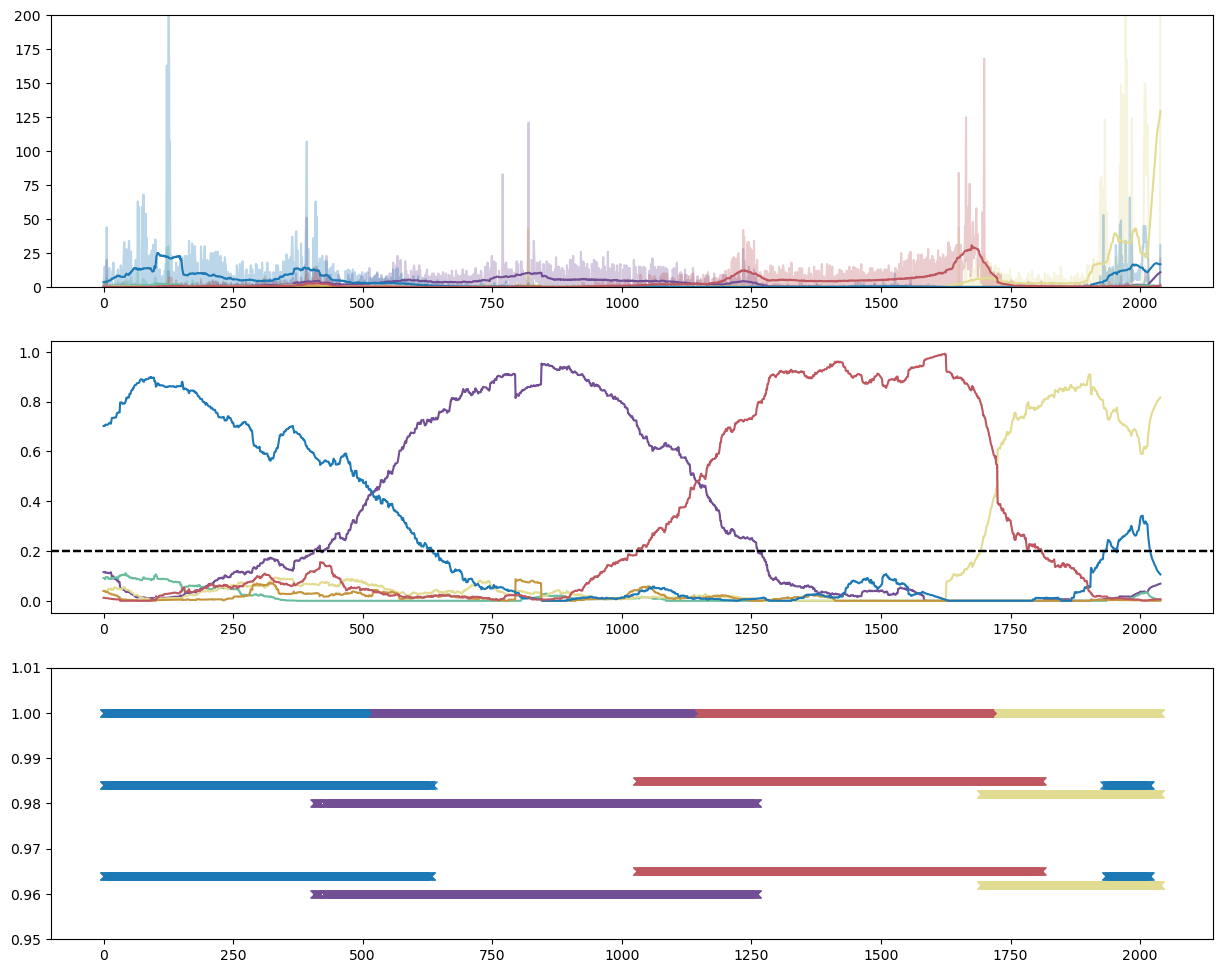

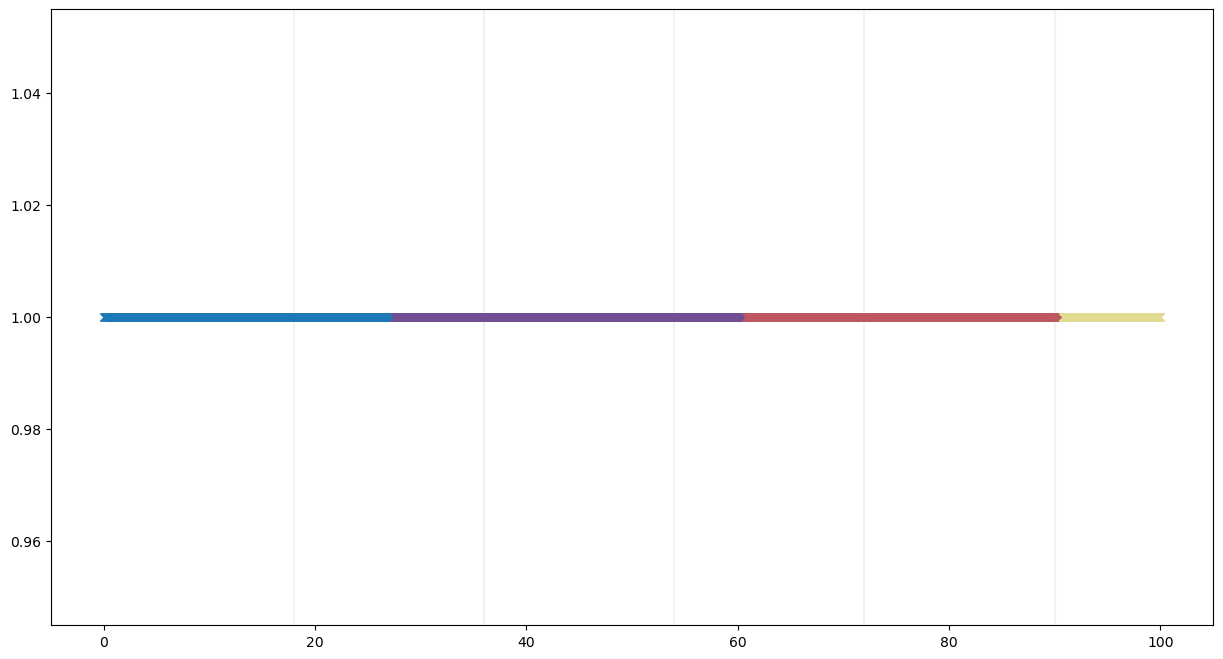

In [38]:
with open(PP_PATH + file + "\\analysis_output\\" + "spikes_seq_type_adjusted.pickle", "rb") as input_file:
    unmasked_spikes_df = pickle.load(input_file)

FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\projects\\sequence_squad\\ppseq_finalised_publication_data\\expert\\awake\\\\seq006_1_8_run_1102025_0102\\analysis_output\\spikes_seq_type_adjusted.pickle'

In [34]:
dat_path

'Z:\\projects\\sequence_squad\\revision_data\\organised_data\\animals\\\\seq006_implant1\\recording8_25-11-2024'

# garbage?

In [ ]:
standard = True
list_ = ["149_1_3"]


for mouse_session_recording in list_:

    print(mouse_session_recording)




    # region = 'striatum'





    ## set ppseq file
    for file_ in os.listdir(PP_PATH):
        if mouse_session_recording in file_:
            file = file_

    save_path = PP_PATH + file + r'\\analysis_output\reordered_recolored\fixed_standard_space\\'

    ## set dat_path:
    for file_ in os.listdir(DAT_PATH):
        if mouse_session_recording.split('_')[0] in file_:
            if mouse_session_recording.split('_')[1] == file_[-1]:
                dat_path = os.path.join(DAT_PATH,file_)
    for recording in os.listdir(os.path.join(DAT_PATH,dat_path)):
        if recording.split('_')[0][9::] == mouse_session_recording.split('_')[-1]:
            dat_path = os.path.join(dat_path,recording)

    # set tracking path
    for file_ in os.listdir(dat_path + r"\video\tracking\\"):
        if 'task' in file_:
            if not 'clock' in file_:
                tracking_path = os.path.join(dat_path + r"\video\tracking\\",file_) + '\\'
    # set video paths
    for file_ in os.listdir(dat_path + r"\video\videos\\"):
        if 'task' in file_:
            if not 'clock' in file_:
                cam_path = os.path.join(dat_path + r"\video\videos\\",file_) + '\\' 
                for vid_file in os.listdir(cam_path):
                    if 'back' in vid_file and '.avi' in vid_file:
                        back_cam_avi_path = os.path.join(cam_path,vid_file)
                    if 'side' in vid_file and '.avi' in vid_file:
                        side_cam_avi_path = os.path.join(cam_path,vid_file)


    print('\n')
    print("LOADING processed_spike_data")
    ### load in releavent things:

    with open(PP_PATH + file + "\\analysis_output\\" + "spikes_seq_type_adjusted.pickle", "rb") as input_file:
        spikes_seq_type_adjusted = pickle.load(input_file)

    import pickle
    with open(PP_PATH + file + "\\analysis_output\\" + "spikes_seq_type_adjusted.pickle", "rb") as input_file:
        unmasked_spikes_df = pickle.load(input_file)

    with open(os.path.join(os.path.join(PP_PATH,file) + r"\analysis_output\reordered_recolored\neuron_order"), "rb") as input_file:
        neuron_order = pickle.load(input_file)

    with open(os.path.join(os.path.join(PP_PATH,file) + r"\analysis_output\reordered_recolored\colors"), "rb") as input_file:
        colors = pickle.load(input_file)

    with open(os.path.join(os.path.join(PP_PATH,file) + r"\analysis_output\reordered_recolored\neuron_index"), "rb") as input_file:
        neuron_index = pickle.load(input_file)

    with open(PP_PATH + file + "\\analysis_output\\" + "latent_event_history_df_split.pickle", "rb") as input_file:
        latent_event_history_df_split = pickle.load(input_file)

    ordered_preferred_type = np.load(PP_PATH + file + "\\analysis_output\\" + 'ordered_preferred_type.npy')

    bkgd_log_proportions_array = pd.read_csv(PP_PATH + file + r"\bkgd_log_proportions_array.csv")


    ##### load deeplabcut tracking data
    print('\n')
    print("LOADING DLC TRACKING DATA")
    back_head_centre = load_H5_bodypart(tracking_path,'back','head_centre')
    back_p1,back_p2,back_p3,back_p4,back_p5 = load_H5_ports(tracking_path,'back')


    ## load in the timespan used for pppseq:
    input_params_path = os.path.join(PP_PATH + file,'trainingData\\') + ('params_' + mouse_session_recording +'.json')
    # Opening JSON file
    f = open(input_params_path)
    # returns JSON object as  a dictionary
    input_config = json.load(f)
    behav_time_interval_start = input_config['time_span'][0]
    print(f"      A corresponding time span has been found. Time span set to {behav_time_interval_start}")


    ## LOAD behaviour data
    print('\n')
    print("LOADING BEHAV DATA")
    try:
        behav_sync = pd.read_csv(dat_path + r'\behav_sync\2_task\Behav_Ephys_Camera_Sync.csv')
        transitions = pd.read_csv(dat_path + r'\behav_sync\2_task\Transition_data_sync.csv')
    except:
        behav_sync = pd.read_csv(dat_path + r'\behav_sync\1_task\Behav_Ephys_Camera_Sync.csv')
        transitions = pd.read_csv(dat_path + r'\behav_sync\1_task\Transition_data_sync.csv')

    behav_mask = (behav_sync.PokeIN_EphysTime>behav_time_interval_start[0])*(behav_sync.PokeIN_EphysTime<behav_time_interval_start[1])
    poke_in_times = (behav_sync[behav_mask].PokeIN_EphysTime) - behav_time_interval_start[0]
    ports = behav_sync[behav_mask].Port
    print('done')



    timeframe = [0,200]

    #mask
    # spikemask
    mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])

    fig, [ax1,ax2,ax3] = plt.subplots(3, 1,figsize=(30, 15))

    1 ### plot ordered ppseq spikes as above:

    # plot background in grey 
    background_keep_mask = unmasked_spikes_df[mask].sequence_type_adjusted <= 0
    ax1.scatter(unmasked_spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=40, linewidth=0,color = 'grey' ,alpha=0.5)
    # mask to remove background neurons from the color plot
    background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
    c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
    ax1.scatter(unmasked_spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)


    ### bin the spiking and plot number of spikes for each seq type
    seqs = np.unique(unmasked_spikes_df.sequence_type_adjusted)
    seq_spikes = []
    for seq_type_ in seqs:  
        seq_spikes += [unmasked_spikes_df.timestamp[np.where(unmasked_spikes_df.sequence_type_adjusted ==seq_type_)[0]].values]

    # Define the bin size (in this case, 0.2s)
    bin_size = 0.2

    seq_spike_occurance = []
    for spikes_ in seq_spikes:
        # Use the numpy.histogram function to bin the data
        hist, bins = np.histogram(spikes_, bins=np.arange(0, np.diff(behav_time_interval_start)[0], bin_size))
        seq_spike_occurance += [list(hist)]

    strt_ = int(timeframe[0]/bin_size)
    end_ = int(timeframe[1]/bin_size)

    for i in range (1,len(seq_spike_occurance)):
    #     ax2.plot(seq_spike_occurance[i][strt_:end_], c = colors[i])
        ax2.plot(convolve_movmean(seq_spike_occurance[i][strt_:end_],3), c = colors[i])


    ## plot the current seq type (based on binned spiking):
    nth_vectors = conactinate_nth_items(seq_spike_occurance[1::])
    max_index= []
    max_index += [np.argmax(sublist) for sublist in nth_vectors] 

    ax2.plot(max_index[strt_:end_])

    ax2.scatter(np.linspace(0,end_ - strt_-1,end_ - strt_),np.ones(end_ - strt_)*-10, marker = '_',color = np.array(colors)[np.array(max_index)+1][strt_:end_], s = 100)

    ### plot the ppseq latent:

    # mask for the timespan
    latent_timespan_mask = (latent_event_history_df_split.timestamp>timeframe[0])*(latent_event_history_df_split.timestamp<timeframe[-1])

    # ignore anything that is below threshold * max amplitude
    thr_ = 0
    thresh_value = max(latent_event_history_df_split.amplitude) * thr_


    amplitude_mask = latent_event_history_df_split[latent_timespan_mask].amplitude > thresh_value

    c_l = np.array(colors)[latent_event_history_df_split[latent_timespan_mask][amplitude_mask].seq_type.values.astype(int)]
    ax3.scatter(latent_event_history_df_split[latent_timespan_mask][amplitude_mask].timestamp,latent_event_history_df_split[latent_timespan_mask][amplitude_mask].seq_type ,marker = 'o', s=40, linewidth=0,color = c_l ,alpha=1)


    # SaveFig('seq_identities.png',save_path)

    fps = 60
    if mouse_session_recording == '148_2_2':
        fps = 40

    # behav_mask
    mask_ = (poke_in_times > timeframe[0]) * (poke_in_times < timeframe[1])

    # tracking and ehys times are synced to poke in times so tracking position has to be aligned to first poke in time in this timeframe. 

    # Find the difference between PokeIN_EphysTime and the start of the behavior interval
    interval_pokeIn_spike_times = behav_sync.PokeIN_EphysTime[behav_mask][mask_].values - behav_time_interval_start[0]
    # Find the offset between the first poke in time and the start of the timeframe
    tracking_offset = interval_pokeIn_spike_times[0] - timeframe[0]

    # Get the first synced time for the camera in the interval 
    interval_cam_times =  behav_sync.backcam_aligned_pokein_times[behav_mask][mask_].values[0]
    # Align the tracking start with the ephys by subtracting the offset
    cam_start_time = interval_cam_times - tracking_offset

    # Calculate the number of events based on the timeframe size and bin size
    events = np.diff(timeframe)[0] /bin_size 
    # Create a list for start times, with the first start time being the camera start time converted to timestamps - 60fps
    start_ts = [cam_start_time * fps ]
    # Convert the bin size to timestamps - 60fps
    bin_ts = bin_size * fps

    # Create an empty list for end times
    end_ts = []
    # Loop through the number of events
    for i in range(int(events)):
        # If it is not the first event, set the start time as the end time of the previous event
        if i > 0:
            start_ts += [end_ts[i-1]]
        # Add the current start time plus the bin size to the list of end times
        end_ts += [start_ts[i] + bin_ts] 



    nrow = 1 
    ncol = 1
    fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

    for ind, ax in enumerate(fig.axes):
        for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
            ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125)
        for i in range(int(events)):
            ax.plot(back_head_centre['interped_x'].values[int(start_ts[i])-1:int(end_ts[i])+1],back_head_centre['interped_y'].values[int(start_ts[i])-1:int(end_ts[i])+1],'-',color = np.array(colors)[np.array(max_index)+1][strt_:end_][i], alpha = 1)


        min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        ax.set_xlim(min_x,max_x)
        ax.set_ylim(min_y,max_y)

        ax.invert_yaxis()

    ax.set_title('timeframe = ' + str(timeframe))



    # behav_mask for the whole analysed time:
    mask_ = (poke_in_times > 0) * (poke_in_times < np.diff(behav_time_interval_start)[0])
    # tracking and ehys times are synced to poke in times so tracking position has to be aligned to first poke in time in this timeframe. 

    # Find the difference between PokeIN_EphysTime and the start of the behavior interval
    interval_pokeIn_spike_times = behav_sync.PokeIN_EphysTime[behav_mask][mask_].values - behav_time_interval_start[0]
    # Find the offset between the first poke in time and the start of the timeframe
    tracking_offset = interval_pokeIn_spike_times[0]

    # Get the first synced time for the camera in the interval 
    interval_cam_times =  behav_sync.backcam_aligned_pokein_times[behav_mask][mask_].values
    # Align the tracking start with the ephys by subtracting the offset
    cam_start_time = interval_cam_times[0] - tracking_offset
    cam_end_time = cam_start_time + np.diff(behav_time_interval_start)[0]

    cam_start_ts = cam_start_time * fps
    cam_end_ts = cam_end_time * fps

    ## work out colors:

    full_timeframe = [0,np.diff(behav_time_interval_start)[0]]
    # Calculate the number of events based on the timeframe size and bin size
    events = np.diff(full_timeframe)[0] /bin_size 
    # Convert the bin size to timestamps - 60fps
    bin_ts = bin_size * fps


    ### bin the spiking and plot number of spikes for each seq type
    seqs = np.unique(spikes_seq_type_adjusted.sequence_type_adjusted)
    seq_spikes = []
    for seq_type_ in seqs:  
        seq_spikes += [spikes_seq_type_adjusted.timestamp[np.where(spikes_seq_type_adjusted.sequence_type_adjusted ==seq_type_)[0]].values]

    seq_spike_occurance = []
    for spikes_ in seq_spikes:
        # Use the numpy.histogram function to bin the data
        hist, bins = np.histogram(spikes_, bins=np.arange(0, np.diff(behav_time_interval_start)[0], bin_size))
        seq_spike_occurance += [list(hist)]



    ## plot the current seq type (based on binned spiking):
    nth_vectors = conactinate_nth_items(seq_spike_occurance[1::])
    max_index= []
    max_index += [np.argmax(sublist) for sublist in nth_vectors] 

    frame_colors= []
    bin_colors = np.array(colors)[np.array(max_index)+1]
    for bin_color in bin_colors:
        frame_colors += [bin_color] * int(bin_ts)


    # Loop through the number of events to split this up for plotting:
    seg_start_ts = [cam_start_ts] 
    seg_end_ts= []
    for i in range(len(bin_colors)):
        # If it is not the first event, set the start time as the end time of the previous event
        if i > 0:
            seg_start_ts += [seg_end_ts[i-1]]
        # Add the current start time plus the bin size to the list of end times
        if i == len(bin_colors)-1:
            seg_end_ts += [cam_end_ts] 
        else:
            seg_end_ts += [seg_start_ts[i] + bin_ts] 


    nrow = 1 
    ncol = 1
    fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

    for ind, ax in enumerate(fig.axes):
        port_centroids = []
        for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
            ## define rings around important ports: port 5, port2, port 3, port4
            port_centroid = np.median(item['interped_x'].values),np.median(item['interped_y'].values)
            radius = 45
            circle1 = plt.Circle(port_centroid, radius, color='blue', alpha = 0.2)
            ax.add_patch(circle1)
            port_centroids += [port_centroid]
    #         ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125)


        ## plot binned segments individually
        for i in range(len(bin_colors)):
            x = back_head_centre['interped_x'].values[int(seg_start_ts[i])-1:int(seg_end_ts[i])]
            y = back_head_centre['interped_y'].values[int(seg_start_ts[i])-1:int(seg_end_ts[i])]
            ax.plot(x,y,'-',color = bin_colors[i], alpha = 1)



        min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        ax.set_xlim(min_x,max_x)
        ax.set_ylim(min_y,max_y)

        ax.invert_yaxis()

        #save out this data for later plotting and alanylis 
        # trim it down - it doesnt match because we add extra an extra time bin onto the end so that we know what the final left over frames should be coloree
        total_frames = len(back_head_centre['interped_x'].values[int(cam_start_ts)-1:int(cam_end_ts)])

        all_frame_colors = frame_colors[0:total_frames]
        all_x_position = back_head_centre['interped_x'].values[int(cam_start_ts)-1:int(cam_end_ts)]
        all_y_position = back_head_centre['interped_y'].values[int(cam_start_ts)-1:int(cam_end_ts)]


    SaveFig('tracking_port_radius.png',save_path)


    ## find times it comes within ble circles (distance is less than radius)
    ## find times it does so in the order 5,2,3,4,5 with less than 2s between 

    def closest_points(target, points, threshold):
        import math
        closest = []
        indicies = []
        for index,point in enumerate(points):
            distance = math.dist(target,point)
            if distance <= threshold:
                closest.append(point)
                indicies.append(index)
        return closest,indicies

    def find_next_val(index,threshold_breaks,frame_filter,port_type):
        p2_indicies = np.where(threshold_breaks == port_type)[0]
        try:
            p2_min_val = min(i for i in p2_indicies if i > index)
            distance = p2_min_val - index
        except:
            distance = 9999999
        if distance<frame_filter:
            return p2_min_val
        else:
            return -1


    coords = []
    for ind_,item in enumerate(all_x_position):
        coords += [[item,all_y_position[ind_]]]

    threshold_breaks = np.zeros(len(coords))
    # for each port we care about find where the mouse breaks the distcance threshold
    for ind_ in range(1,len(port_centroids)):
        threshold = radius
        target = port_centroids[ind_]
        closest,indicies = closest_points(target, coords, threshold)
        threshold_breaks[indicies] = ind_ + 1

    ## each of these is a frame so we know the timing between them. ie. one frame is 1/60s 
    time_filter = 3 #in s
    frame_filter = int(time_filter / (1/fps))


    # #find times when the mouse does the sequence:


    if standard:

        start_ind = []
        end_ind = []
        P5_in_ind = []
        index = 0
        while index < len(threshold_breaks[:-1]):
        # for index,break_ in enumerate(threshold_breaks[:-1]):
            break_ = threshold_breaks[index]
            if break_ == 5 and not threshold_breaks[index+1] ==5:
                # find min valin this that is larger than current - ie. next index
                p2_ind = find_next_val(index,threshold_breaks,frame_filter,2)
                if p2_ind != -1:
                    # find min valin this that is larger than current - ie. next index
                    p3_ind = find_next_val(p2_ind,threshold_breaks,frame_filter,3)
                    if p3_ind != -1:
                        # find min valin this that is larger than current - ie. next index
                        p4_ind = find_next_val(p3_ind,threshold_breaks,frame_filter,4)
                        if p4_ind != -1:
                            # find min valin this that is larger than current - ie. next index
                            p5_ind = find_next_val(p4_ind,threshold_breaks,frame_filter,5)
                            if p5_ind != -1:
                                p5_out_ind = find_next_val(p5_ind,threshold_breaks,frame_filter,0)
                                if p5_out_ind != -1:
                                    start_ind += [index]
                                    end_ind += [p5_out_ind]
                                    index = p5_out_ind - 1
                                else: 
                                    index +=1
                            else: 
                                index += 1
                        else: 
                            index += 1
                    else: 
                        index += 1
                else: 
                    index += 1
            else: 
                index += 1


    else:
    # # ### for times the mouse dopesnt go near port 4

        start_ind = []
        end_ind = []
        P5_in_ind = []
        index = 0
        while index < len(threshold_breaks[:-1]):
        # for index,break_ in enumerate(threshold_breaks[:-1]):
            break_ = threshold_breaks[index]
            if break_ == 5 and not threshold_breaks[index+1] ==5:
                # find min valin this that is larger than current - ie. next index
                p2_ind = find_next_val(index,threshold_breaks,frame_filter,2)
                if p2_ind != -1:
                    # find min valin this that is larger than current - ie. next index
                    p3_ind = find_next_val(p2_ind,threshold_breaks,frame_filter,3)
                    if p3_ind != -1:
                        # find min valin this that is larger than current - ie. next index
                        p5_ind = find_next_val(p3_ind,threshold_breaks,frame_filter,5)
                        # check whether once it breaks out of the port 3 radius it reenters this or enters port 4 before it goes into port 5 
                        next_p3_break = find_next_val(p3_ind,threshold_breaks,frame_filter,0)
                        n_p3_ind = find_next_val(next_p3_break,threshold_breaks,frame_filter,3)
                        n_p4_ind = find_next_val(next_p3_break,threshold_breaks,frame_filter,4)
                        if n_p3_ind == -1 or p5_ind <n_p3_ind: 
                            if n_p4_ind == -1 or p5_ind <n_p4_ind:
                                if p5_ind != -1:
                                    p5_out_ind = find_next_val(p5_ind,threshold_breaks,frame_filter,0)
                                    if p5_out_ind != -1:
                                        start_ind += [index]
                                        end_ind += [p5_out_ind]
                                        index = p5_out_ind - 1
                                    else: 
                                        index +=1
                                else: 
                                    index += 1
                            else: 
                                index += 1
                        else: 
                            index += 1
                    else: 
                        index += 1
                else: 
                    index += 1
            else: 
                index += 1

    filtered_split_trajectories_x_positions = []
    filtered_split_trajectories_y_positions = []
    filtered_split_trajectories_frame_colors = []

    # plot these filtered trajectories:

    nrow = 1 
    ncol = 1
    fig, axs = plt.subplots(nrow, ncol,figsize=(10, 4))

    for ind, ax in enumerate(fig.axes):

        for port_centroid in port_centroids:
            ## define rings around important ports: port 5, port2, port 3, port4
            radius = 45
            circle1 = plt.Circle(port_centroid, radius, color='blue', alpha = 0.2)
            ax.add_patch(circle1)

    for i in range(len(start_ind)):


        ax.plot(all_x_position[start_ind[i]:end_ind[i]],all_y_position[start_ind[i]:end_ind[i]],'-', color = 'grey', alpha = 1)

        filtered_split_trajectories_x_positions += [all_x_position[start_ind[i]:end_ind[i]]]
        filtered_split_trajectories_y_positions += [all_y_position[start_ind[i]:end_ind[i]]]
        filtered_split_trajectories_frame_colors += [all_frame_colors[start_ind[i]:end_ind[i]]]

        min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        ax.set_xlim(min_x,max_x)
        ax.set_ylim(min_y,max_y)


        ax.invert_yaxis()

    import math 

    def find_closest_point(target, points):
        min_distance = float('inf')
        closest_point = None
        closest_index = None
        for index, point in enumerate(points):
            distance = math.dist(target,point)
            if distance < min_distance:
                min_distance = distance
                closest_point = point
                closest_index = index    
        return closest_point,closest_index

    def find_closest_points(traject_coords, port_centroids):
        split_trajects_port_points = []
        split_trajects_port_indicies = []    
        closest_points = []
        closest_inds = []
        for ind_,centroids in enumerate(port_centroids[1::]):
            # skip 0 ^see above and skip port 3: 
            if not centroids == port_centroids[2]:
                if not centroids == port_centroids[-1]:
                    closest_point, closest_index = find_closest_point(centroids, traject_coords)
                    closest_points += [closest_point]
                    closest_inds += [closest_index]
                else:
                    # if port 5 search from port 4 onwards
                    closest_point, closest_index = find_closest_point(centroids, traject_coords[closest_inds[-1]::])
                    closest_points += [closest_point]
                    closest_inds += [closest_index + closest_inds[-1]]

        ###make it so that point closest to port 1 can only be between port 5 and 2! 
        closest_point_1, closest_index_1 = find_closest_point(port_centroids[0],traject_coords[0:closest_inds[0]])

        ###make it so that point closest to port 3 can only be between port 2 and 4!
        if closest_inds[0] < closest_inds[1]: 
            closest_point_3, closest_index_3 = find_closest_point(port_centroids[2],traject_coords[closest_inds[0]:closest_inds[1]])
            closest_index_3 = closest_index_3 + closest_inds[0]    
            split_trajects_port_points += [[closest_point_1] + [closest_points[0]] + [closest_point_3] + closest_points[1::]]
            split_trajects_port_indicies += [[closest_index_1] + [closest_inds[0]] + [closest_index_3] + closest_inds[1::]]
            return split_trajects_port_points, split_trajects_port_indicies, traject_coords
        else:
            traject_coords = []
            return [], [], traject_coords  # delete these coords
        # this finds relative ind so I need to add on the offst from the start of the full traject
        # print(closest_index_3)

    ############################################## find points in each trajectory that are closest to the end port 
    split_trajects_port_points = []
    split_trajects_port_indicies = []
    combined_xy_trajectories = []
    sup_idx = [] # trajectories to suppress if no closest points found due to abnormal traj
    for i in range(len(filtered_split_trajectories_x_positions)):
        traject_coords = []
        for ind_,item in enumerate(filtered_split_trajectories_x_positions[i]):
            traject_coords += [[item, filtered_split_trajectories_y_positions[i][ind_]]]

        split_trajects_port_points_, split_trajects_port_indicies_, traject_coords = find_closest_points(traject_coords, port_centroids)
        if traject_coords == []:  # traject suppressed due to weird trajectory
            sup_idx.append(i)
        else:
            split_trajects_port_points += split_trajects_port_points_
            split_trajects_port_indicies += split_trajects_port_indicies_
            combined_xy_trajectories += [traject_coords]
    # delete weird trajectories
    filtered_split_trajectories_x_positions = np.delete(filtered_split_trajectories_x_positions, sup_idx, axis=0)
    filtered_split_trajectories_y_positions = np.delete(filtered_split_trajectories_y_positions, sup_idx, axis=0)
    N_trajectory = len(filtered_split_trajectories_x_positions) # new number of trajectories after deleting weird ones
    print("Number of trajectories without weird ones: ", N_trajectory)

    nrow = 1 
    ncol = 1
    fig, axs = plt.subplots(nrow, ncol,figsize=(10, 6))
    for ind, ax in enumerate(fig.axes):
        for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
            ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125,alpha = 0.2)
        min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        ax.set_xlim(min_x,max_x)
        ax.set_ylim(min_y,max_y)
        ax.invert_yaxis()
        for j in range(len(filtered_split_trajectories_x_positions)):
            for i in range(len(filtered_split_trajectories_x_positions[j])):
                if i in split_trajects_port_indicies[j]:
                    _colors_ = 'red'
                    alpha_ = 1
                else:
                    _colors_ = 'grey'
                    alpha_ = 0.2
                ax.plot(filtered_split_trajectories_x_positions[j][i],filtered_split_trajectories_y_positions[j][i],'x', color = _colors_, alpha = alpha_ )

    segments_1 = []
    segments_2 = []
    segments_3 = []
    segments_4 = []
    segments_5 = []
    segments_6 = []
    for ind,traject_ in enumerate(combined_xy_trajectories):
        segments_1 += [traject_[0:split_trajects_port_indicies[ind][0]]]
        segments_2 += [traject_[split_trajects_port_indicies[ind][0]:split_trajects_port_indicies[ind][1]]]
        segments_3 += [traject_[split_trajects_port_indicies[ind][1]:split_trajects_port_indicies[ind][2]]]
        segments_4 += [traject_[split_trajects_port_indicies[ind][2]:split_trajects_port_indicies[ind][3]]]
        segments_5 += [traject_[split_trajects_port_indicies[ind][3]:split_trajects_port_indicies[ind][4]]]
        segments_6 += [traject_[split_trajects_port_indicies[ind][4]:]]

    segments = [segments_1] + [segments_2] + [segments_3] + [segments_4] + [segments_5] #+ [segments_6]

    from scipy.interpolate import interp1d
    def interpolate_to_longest_and_find_average_curve(curves):
        # Find the length of the longest curve
        max_length = max([len(curve) for curve in curves])
        # Interpolate each curve to the length of the longest curve
        interpolated_curves = []
        for curve in curves:
            if len(curve) > 0:
                x = [point[0] for point in curve]
                y = [point[1] for point in curve]

                # find lots of points on the piecewise linear curve defined by x and y
                M = max_length
                t = np.linspace(0, len(x), M)
                x_interp = np.interp(t, np.arange(len(x)), x)
                y_interp = np.interp(t, np.arange(len(y)), y)

                interpolated_curves.append([[x, y] for x, y in zip(x_interp, y_interp)])
            # # Average the x and y coordinates of all the interpolated curves
            average_curve = []
            for i in range(max_length):
                x_sum = 0
                y_sum = 0
                for curve in interpolated_curves:
                    x_sum += curve[i][0]
                    y_sum += curve[i][1]
                average_curve.append([x_sum / len(curves), y_sum / len(curves)])
        return average_curve

    a_curves= []
    for segment in segments:
        a_curves += [interpolate_to_longest_and_find_average_curve(segment)]
    a_curve_ = []
    for a_curve in a_curves:
        a_curve_ += a_curve
    # add the start back onto the end so that it is a complete loop
    a_curve_ += [a_curve_[0]]

    nrow = 2 
    ncol = 1
    fig, axs = plt.subplots(nrow, ncol,figsize=(8, 5))
    for ind, ax in enumerate(fig.axes):
        for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
            ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125,alpha = 0.2)
        min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        ax.set_xlim(min_x,max_x)
        ax.set_ylim(min_y,max_y)
        ax.invert_yaxis()

        for segment in segments:
            for seg_traject in segment:
                x = [point[0] for point in seg_traject]
                y = [point[1] for point in seg_traject]
                ax.plot(x, y, '-', color ='grey',alpha = 0.4)

        if ind == 0:
            for a_curve in a_curves:
                x = [point[0] for point in a_curve]
                y = [point[1] for point in a_curve]
                ax.plot(x, y, color = 'red')
        else:
            x = [point[0] for point in a_curve_]
            y = [point[1] for point in a_curve_]
            ax.plot(x, y, '-',color = 'green')

    def total_length_of_curve(curve):
        x = [point[0] for point in curve]
        y = [point[1] for point in curve]
        dists = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
        return np.sum(dists)

    total_length = total_length_of_curve(a_curve_)
    # chose number of points you want to construct the curve out of - this will only be roughly fitted as the code does a lot of rounding. This cant be smaller than the current length - ifyou do this is will just keep the curve the same (it can only add points)
    num_points = 2000
    print(total_length, num_points)
    # number to multiply the segment length to get the rough breakdown so that we get around 1000 in total 
    segment_warp_factor = num_points/int(total_length) 

    a_curve_copy = np.array(a_curve_.copy())
    data_points = len(a_curve_)
    interpolated_av_curve = [a_curve_copy[0]]
    i=1
    while i < data_points:
        st_ = a_curve_copy[i]
        ed_ = a_curve_copy[i-1]
        seg_distance = math.dist(st_,ed_)
        num_points_to_add = np.round(seg_distance * segment_warp_factor)
        if num_points_to_add >1:
            seg = [st_] + [ed_]
            x = [point[0] for point in seg]
            y = [point[1] for point in seg]
            M = int(num_points_to_add)
            t = np.linspace(0, len(x), M)
            x_interp = np.interp(t, np.arange(len(x)), x)
            y_interp = np.interp(t, np.arange(len(y)), y)
            interpolated_av_curve += ([[x, y] for x, y in zip(reversed(x_interp), reversed(y_interp))])  # reversed is needed to extrapolate in the right sens in a continous way.
            i+=1
        else:
            interpolated_av_curve += [a_curve_copy[i]]
            i+=1                
    # find points that are closest to each port:
    av_curve_closestport_points, av_curve_closestport_indicies, interpolated_av_curve = find_closest_points(interpolated_av_curve, port_centroids)

    nrow = 1 
    ncol = 1
    fig, axs = plt.subplots(nrow, ncol,figsize=(10, 6))
    for ind, ax in enumerate(fig.axes):

        for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
            ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125,alpha = 0.2)
        min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
        min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
        ax.set_xlim(min_x,max_x)
        ax.set_ylim(min_y,max_y)
        ax.invert_yaxis()

        x = [point[0] for point in interpolated_av_curve]
        y = [point[1] for point in interpolated_av_curve]
        ax.plot(x, y, 'x',color = 'green')

        for index in av_curve_closestport_indicies[0]:
            ax.plot(interpolated_av_curve[index][0],interpolated_av_curve[index][1],'o', color = 'red', alpha = 1 )

    from scipy.spatial import KDTree
    def closest_point(line1, line2):
        tree = KDTree(line2)
        dist, index = tree.query(line1)
        ret

In [13]:
i

18

In [345]:
combined_xy_trajectories[i]

[[728.5374755859375, 532.5908813476562],
 [719.2994995117188, 544.0459594726562],
 [708.4381713867188, 557.3870239257812],
 [697.2095947265625, 567.2888793945312],
 [687.6544189453125, 572.863525390625],
 [681.0866088867188, 575.8187255859375],
 [673.7462158203125, 574.808349609375],
 [667.46484375, 571.2169189453125],
 [659.2620849609375, 569.497802734375],
 [653.6602783203125, 567.1762084960938],
 [643.6522216796875, 569.4232788085938],
 [633.2275390625, 576.2958374023438],
 [623.6096801757812, 583.6443481445312],
 [615.8648071289062, 588.3605346679688],
 [610.880859375, 591.0169677734375],
 [607.6881103515625, 593.455322265625],
 [605.4740600585938, 593.0589599609375],
 [603.6467895507812, 593.4483032226562],
 [603.6467895507812, 593.4483032226562],
 [602.3999633789062, 598.0303955078125],
 [601.1531372070312, 602.6124877929688],
 [599.9063110351562, 607.194580078125],
 [598.6594848632812, 611.7766723632812],
 [601.4824829101562, 613.43408203125],
 [599.9456176757812, 613.9231567382

In [344]:
av_curve_closestport_indicies[i]

IndexError: list index out of range

In [341]:
traject

[]

In [298]:
extra_piece = 50
for i in range(len(combined_xy_trajectories)):
    #find closest point from start to port to port 2
    traject = combined_xy_trajectories[i][0:split_trajects_port_indicies[i][1]]
    end_segment = av_curve_closestport_indicies[0][1]
    index, dist = closest_point(traject, interpolated_av_curve[0:end_segment+extra_piece])
    closest_inds = list(index)

    #find closest point from port 2 to port 4
    traject = combined_xy_trajectories[i][split_trajects_port_indicies[i][1]:split_trajects_port_indicies[i][3]]
    start_segment = av_curve_closestport_indicies[0][1]
    end_segment = av_curve_closestport_indicies[0][3]
    index, dist = closest_point(traject, interpolated_av_curve[start_segment-extra_piece:end_segment+10])
    #indicies are calcuated reltive to segment so add on previous segment inds
    closest_inds += list(index+av_curve_closestport_indicies[0][1])

    #find closest point from port 4 to port 5
    traject = combined_xy_trajectories[i][split_trajects_port_indicies[i][3]:split_trajects_port_indicies[i][4]]
    start_segment = av_curve_closestport_indicies[0][3]
    end_segment = av_curve_closestport_indicies[0][4]
    index, dist = closest_point(traject, interpolated_av_curve[start_segment+10:end_segment+extra_piece])
    closest_inds += list(index+av_curve_closestport_indicies[0][3])

    #find closest point from port 5 to the rest
    traject = combined_xy_trajectories[i][split_trajects_port_indicies[i][4]::]
    start_segment = av_curve_closestport_indicies[0][4]
    index, dist = closest_point(traject, interpolated_av_curve[start_segment-extra_piece::])
    closest_inds += list(index+av_curve_closestport_indicies[0][4])

    closest_indicies += [closest_inds]

ValueError: x must consist of vectors of length 2 but has shape (0,)

In [311]:
len(combined_xy_trajectories)

52

In [302]:
combined_xy_trajectories[i][split_trajects_port_indicies[i][4]::]

[[743.6930541992188, 548.5460815429688]]

In [307]:
split_trajects_port_indicies[i][3]

269

In [308]:
split_trajects_port_indicies[i][4]

269

In [310]:
len(split_trajects_port_indicies)

52

In [313]:
i


33

In [292]:

curves = segment

# Find the length of the longest curve
max_length = max([len(curve) for curve in curves])
# Interpolate each curve to the length of the longest curve
interpolated_curves = []
for curve in curves:
    if len(curve) > 0:
        x = [point[0] for point in curve]
        y = [point[1] for point in curve]

        # find lots of points on the piecewise linear curve defined by x and y
        M = max_length
        t = np.linspace(0, len(x), M)
        x_interp = np.interp(t, np.arange(len(x)), x)
        y_interp = np.interp(t, np.arange(len(y)), y)

        interpolated_curves.append([[x, y] for x, y in zip(x_interp, y_interp)])
    # # Average the x and y coordinates of all the interpolated curves
    average_curve = []
    for i in range(max_length):
        x_sum = 0
        y_sum = 0
        for curve in interpolated_curves:
            x_sum += curve[i][0]
            y_sum += curve[i][1]
        average_curve.append([x_sum / len(curves), y_sum / len(curves)])


In [290]:
curve

[]

In [291]:
curves

[[[709.1438598632812, 582.6004028320312],
  [707.817626953125, 583.134521484375],
  [705.955810546875, 581.028076171875],
  [705.108154296875, 575.0968627929688],
  [707.0172729492188, 568.3534545898438],
  [709.887451171875, 560.1802978515625],
  [716.0909423828125, 550.1770629882812],
  [723.5150756835938, 540.7108764648438],
  [731.5484619140625, 530.1320190429688],
  [738.5413208007812, 520.6961059570312],
  [742.8779907226562, 516.4205322265625],
  [745.3588256835938, 513.92041015625],
  [748.5420532226562, 513.5328979492188],
  [751.8311767578125, 513.3002319335938],
  [753.2105102539062, 514.8832397460938],
  [753.7671508789062, 516.0345458984375],
  [754.871337890625, 516.2947387695312],
  [756.6646728515625, 516.589111328125],
  [757.6542358398438, 518.0767822265625],
  [759.3781127929688, 518.318603515625],
  [759.6487426757812, 517.6156005859375],
  [758.43212890625, 517.3466796875],
  [758.6073608398438, 516.3713989257812],
  [760.3876342773438, 515.9893188476562],
  [760.6

In [276]:
for recording in os.listdir(os.path.join(DAT_PATH,dat_path)):
    if recording.split('_')[0][9::] == mouse_session_recording.split('_')[-1]:
        dat_path = os.path.join(dat_path,recording)
        

'Z:\\projects\\sequence_squad\\organised_data\\animals\\\\EJT268_implant1'

In [277]:
recording

'recording9_05-12-2023'

In [278]:
mouse_session_recording

'268_1_10'

In [279]:
os.listdir(os.path.join(DAT_PATH,dat_path))

['recording10_05-15-2023',
 'recording1_05-01-2023',
 'recording2_05-02-2023',
 'recording3_05-03-2023',
 'recording4_05-05-2023',
 'recording5_05-08-2023',
 'recording6_05-09-2023',
 'recording7_05-10-2023',
 'recording8_05-11-2023',
 'recording9_05-12-2023']